In [1]:
import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import movecolumn as mc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

plt.rcParams['figure.figsize'] = [14, 3]


# Предобработка данных

Dataset from: https://github.com/itmo-ml-lab-ML-course/parser-imorda

In [2]:
raw_df = pd.read_csv('data/result.csv')
raw_df

,Unnamed: 0,name,body_type,modification_name,price_min,price_max,country,classe,doors_count,seats_count,...,engine_max_power_rpm,engine_max_torque,engine_max_torque_rpm,engine_cylinders_position,engine_cylinders_count,engine_valves_per_cylinder,engine_intake_type,engine_compression,engine_cylinder_diameter,engine_piston_stroke
0,0,Nissan Gloria X (Y33),Седан,2.0 AT,-1,-1,Япония,E,4,5,...,6000,167,3200,V-образное,6,-1,распределенный впрыск (многоточечный),10.0,78.0,70.0
1,1,Nissan Gloria X (Y33),Седан,2.5 AT,230000,230000,Япония,E,4,5,...,6400,235,4000,V-образное,6,4,распределенный впрыск (многоточечный),10.0,85.0,73.0
2,2,Nissan Gloria X (Y33),Седан,2.5 AT,-1,-1,Япония,E,4,5,...,6400,275,4800,рядное,6,4,распределенный впрыск (многоточечный),10.0,86.0,72.0
3,3,Nissan Gloria X (Y33),Седан,3.0 AT,-1,-1,Япония,E,4,5,...,5200,248,3200,V-образное,6,2,распределенный впрыск (многоточечный),9.0,87.0,83.0
4,4,Nissan Gloria X (Y33),Седан,3.0 AT,-1,-1,Япония,E,4,5,...,6000,368,3600,V-образное,6,4,непосредственный впрыск (прямой),9.0,87.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58279,58279,Toyota Avensis I Рестайлинг,Лифтбек,2.0 AT,-1,-1,Япония,D,5,5,...,5700,200,4000,рядное,4,4,распределенный впрыск (многоточечный),9.0,86.0,86.0
58280,58280,Toyota Avensis II,Седан,2.2 MT,-1,-1,Япония,D,4,5,...,3600,310,2000,рядное,4,4,Common rail (Дизель),16.8,86.0,96.0
58281,58281,Toyota Avensis II,Лифтбек,1.8 AT,-1,-1,Япония,D,5,5,...,6000,170,4200,рядное,4,4,распределенный впрыск (многоточечный),10.0,79.0,91.5
58282,58282,Toyota Avensis II,Седан,2.2 MT,-1,-1,Япония,D,4,5,...,3600,310,2000,рядное,4,4,Common rail (Дизель),16.8,86.0,96.0


Кайф, 54 параметра. Предстоит найти в них небесполезные признаки....

Попробуем предсказывать цену автомобиля по его каталожным параметрам

<Axes: >

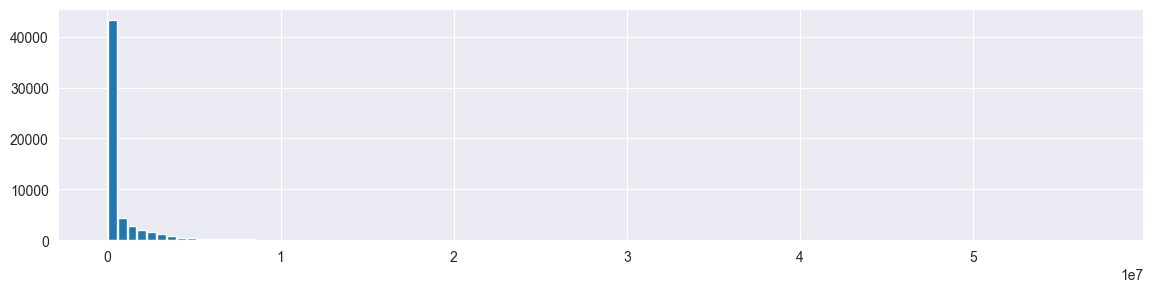

In [3]:
raw_df.price_min.hist(bins=100, rwidth=0.9)

Для начала потрём данные, в которых нет цены, так как её и будем предсказывать (как в train, так и в test выборке нужна цена, надо же как-то что-то валидировать

Замечание: как price_min так и price_max могут быть страшными выбросами, так как низ рынка, как и верх иногда могут неоправдано улетать в космос. Хочется взять медиану рынка, но у нас всего 2 признака (мин и макс). Что ж, остаётся только взять среднее, чтобы хоть как-то с этим справиться.


<Axes: >

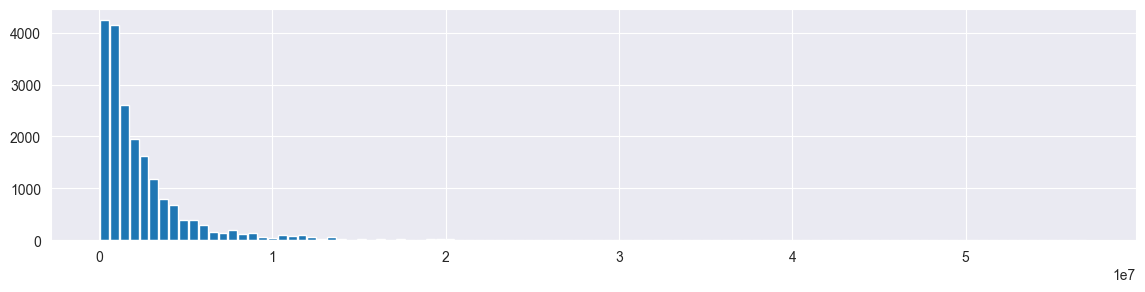

In [4]:
raw_df['price_avg'] = raw_df.price_min + (raw_df.price_max - raw_df.price_min) / 2.

df = raw_df[(raw_df.price_min > 0) & 
            (raw_df.price_max > 0) &
            (raw_df.doors_count > 0)]
df.price_avg.hist(bins=100, rwidth=0.9)

In [5]:
df

,Unnamed: 0,name,body_type,modification_name,price_min,price_max,country,classe,doors_count,seats_count,...,engine_max_torque,engine_max_torque_rpm,engine_cylinders_position,engine_cylinders_count,engine_valves_per_cylinder,engine_intake_type,engine_compression,engine_cylinder_diameter,engine_piston_stroke,price_avg
1,1,Nissan Gloria X (Y33),Седан,2.5 AT,230000,230000,Япония,E,4,5,...,235,4000,V-образное,6,4,распределенный впрыск (многоточечный),10.0,85.0,73.0,230000.0
9,9,Nissan Gloria X (Y33),Седан,2.8 AT,820000,820000,Япония,E,4,5,...,181,2400,рядное,6,2,ТНВД (Дизель),22.0,85.0,83.0,820000.0
60,60,Nissan Gloria XI (Y34),Седан,3.0 AT,510000,510000,Япония,E,4,5,...,387,3600,V-образное,6,4,непосредственный впрыск (прямой),9.0,87.0,83.0,510000.0
63,63,Nissan Gloria XI (Y34),Седан,3.0 CVT,510000,510000,Япония,E,4,5,...,387,3600,V-образное,6,4,непосредственный впрыск (прямой),9.0,87.0,83.0,510000.0
64,64,Nissan Gloria XI (Y34),Седан,2.5 AT,548000,690000,Япония,E,4,5,...,265,4400,V-образное,6,4,непосредственный впрыск (прямой),11.0,85.0,73.0,619000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58264,58264,Toyota Avensis II,Седан,1.8 AT,600000,600000,Япония,D,4,5,...,170,4200,рядное,4,4,распределенный впрыск (многоточечный),10.0,79.0,91.5,600000.0
58266,58266,Toyota Avensis II,Седан,2.0 MT,610000,610000,Япония,D,4,5,...,196,4000,рядное,4,4,непосредственный впрыск (прямой),11.0,86.0,86.0,610000.0
58267,58267,Toyota Avensis II,Седан,2.0 AT,610000,610000,Япония,D,4,5,...,196,4000,рядное,4,4,непосредственный впрыск (прямой),11.0,86.0,86.0,610000.0
58268,58268,Toyota Avensis II,Седан,1.8 MT,600000,600000,Япония,D,4,5,...,170,4200,рядное,4,4,распределенный впрыск (многоточечный),10.0,79.0,91.5,600000.0


Слишком большой разброс цен, ничего не видно. Окэй, логарифмируем

<Axes: >

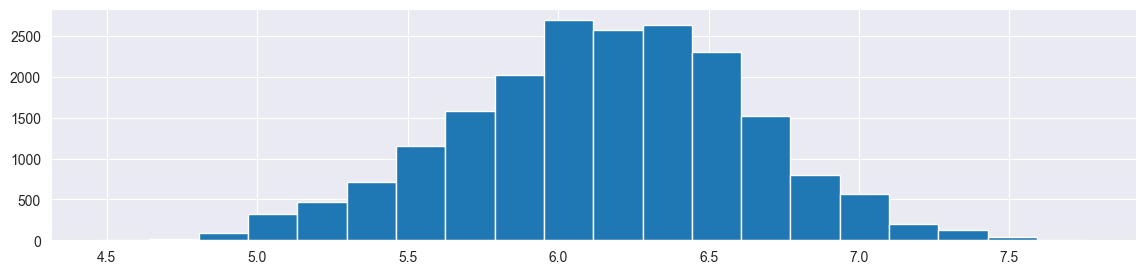

In [6]:
price = df.price_avg
price_log = np.log10(price)
price_log.hist(bins=20)

Omg, это же нормальное распределение, кайф. 
Ну мы поняли, что большинство тачек стоит где-то 1-5 лимонов, супер.

Лан, это вполне возможно предсказывать. 

Теперь задача вытащить из этой свалки полезные фичи...

In [7]:
df.dtypes

Unnamed: 0                      int64
name                           object
body_type                      object
modification_name              object
price_min                       int64
price_max                       int64
country                        object
classe                         object
doors_count                     int64
seats_count                     int64
steering_wheel_side            object
front_suspension_type          object
rear_suspension_type           object
front_brakes_type              object
rear_brakes_type               object
length                          int64
width                           int64
height                          int64
wheelbase                       int64
clearance                       int64
front_track                     int64
rear_track                      int64
max_speed                       int64
zero_to_100                   float64
fuel_consumption_city         float64
fuel_consumption_road         float64
fuel_consump

В целом, можно парсить и onehotить имя, вытаскивая название марки. Всякие мерседесы ожидаются быть более дорогими, чем ВАЗ. Однако, это довольно тупая фича получается, так как мы не можем ограничиться парой марок, лучше смотреть на более прямые признаки (например, класс автомобиля, который в свою очередь не помешает отonehotить)

In [8]:
processed_df = pd.DataFrame()

### Численные признаки

#### Количество дверей

<Axes: >

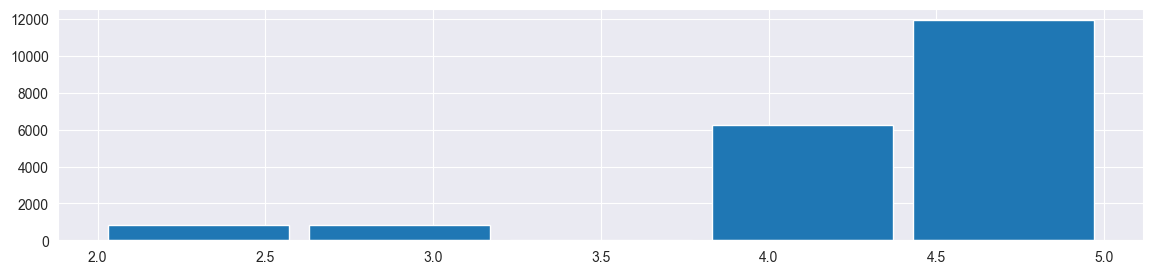

In [9]:
processed_df['doors_count'] = df.doors_count
processed_df.doors_count.hist(bins=5, rwidth=0.9)

#### Количество мест

<Axes: >

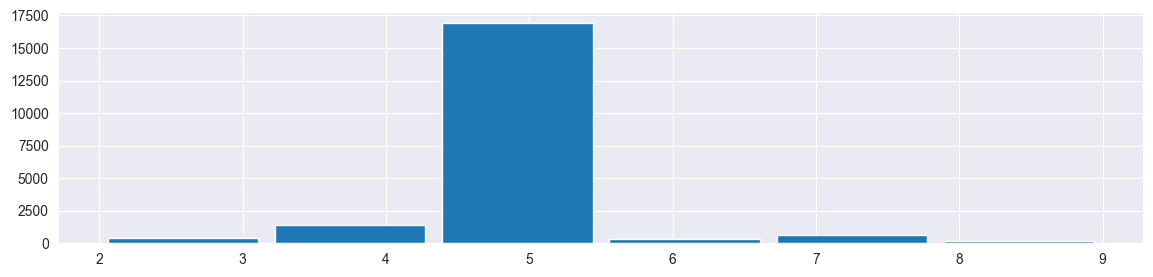

In [10]:
processed_df['seats_count'] = df.seats_count
processed_df.seats_count.hist(bins=6, rwidth=0.9)

#### Длина

<Axes: >

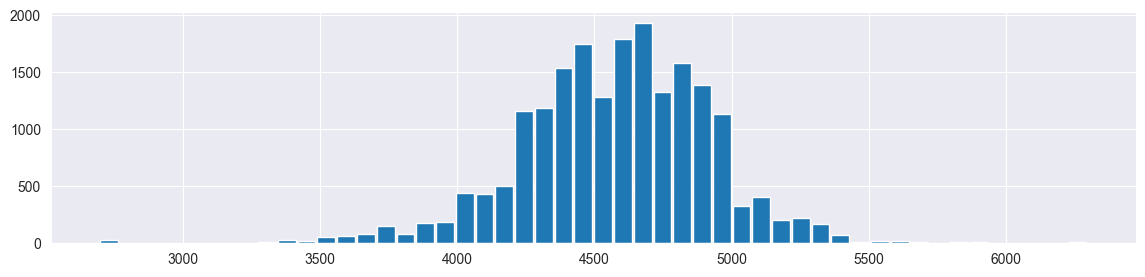

In [11]:
processed_df['length'] = df.length
processed_df.length.hist(bins=50, rwidth=0.9)

#### Ширина

<Axes: >

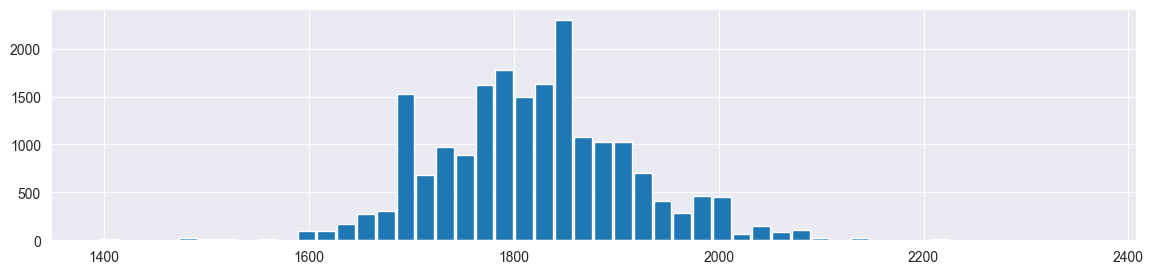

In [12]:
processed_df['width'] = df.width
processed_df.width.hist(bins=50, rwidth=0.9)

#### Высота

<Axes: >

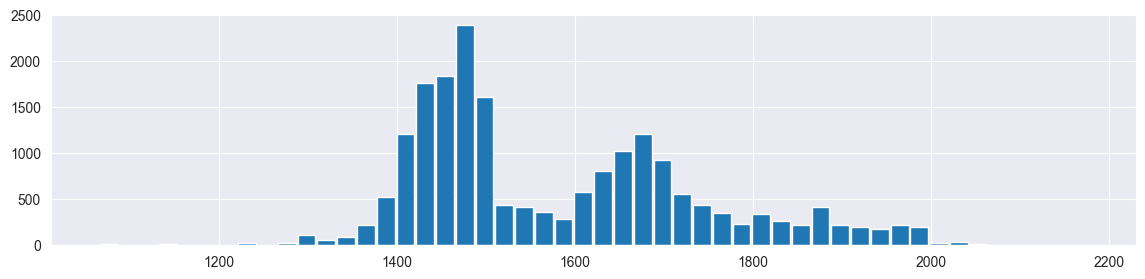

In [13]:
processed_df['height'] = df.height
processed_df.height.hist(bins=50, rwidth=0.9)

#### Колёсная база

<Axes: >

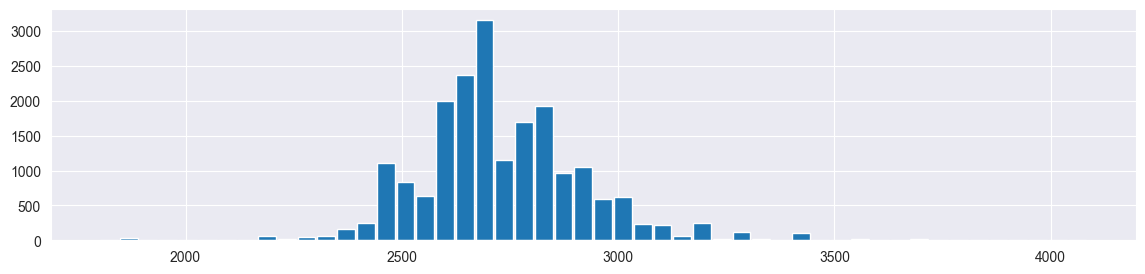

In [14]:
processed_df['wheelbase'] = df.wheelbase
processed_df.wheelbase.hist(bins=50, rwidth=0.9)

#### Клиренс

<Axes: >

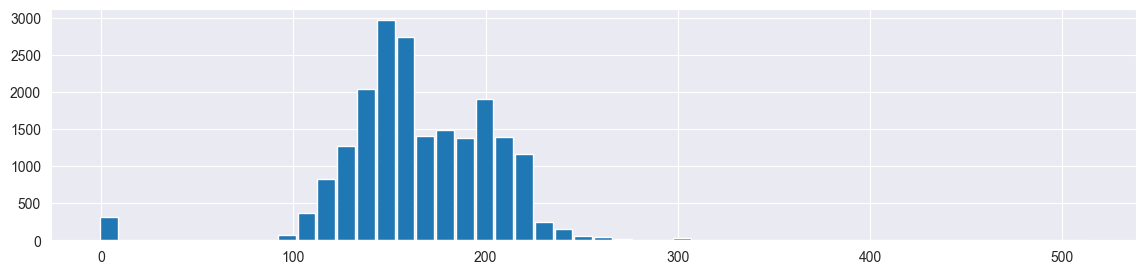

In [15]:
processed_df['clearance'] = df.clearance
processed_df.clearance.hist(bins=50, rwidth=0.9)

#### Передняя колея

<Axes: >

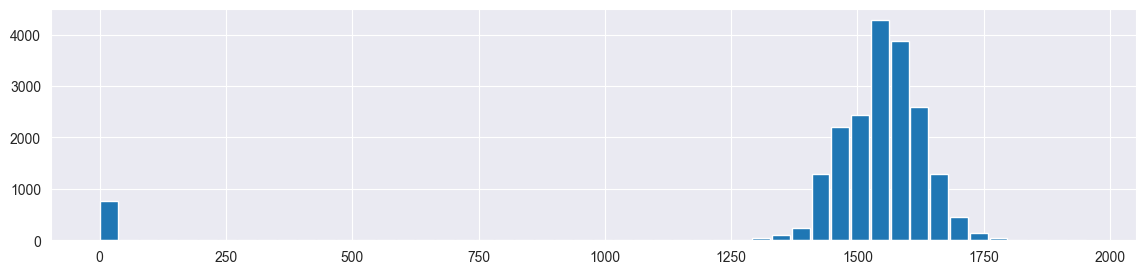

In [16]:
processed_df['front_track'] = df.front_track
processed_df.front_track.hist(bins=50, rwidth=0.9)

#### Задняя колея

<Axes: >

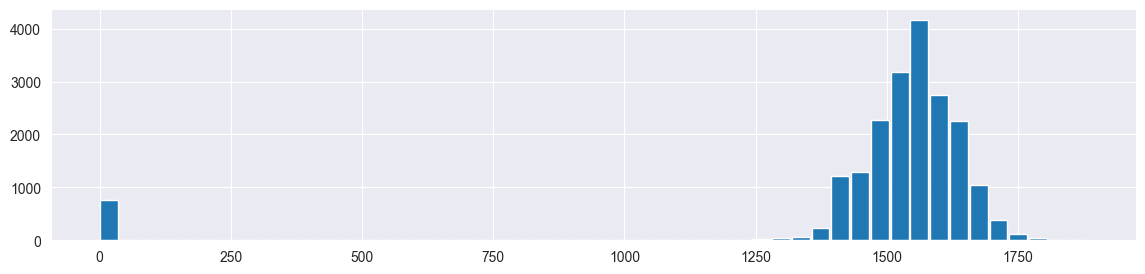

In [17]:
processed_df['rear_track'] = df.rear_track
processed_df.rear_track.hist(bins=50, rwidth=0.9)

#### Максимальная скорость

<Axes: >

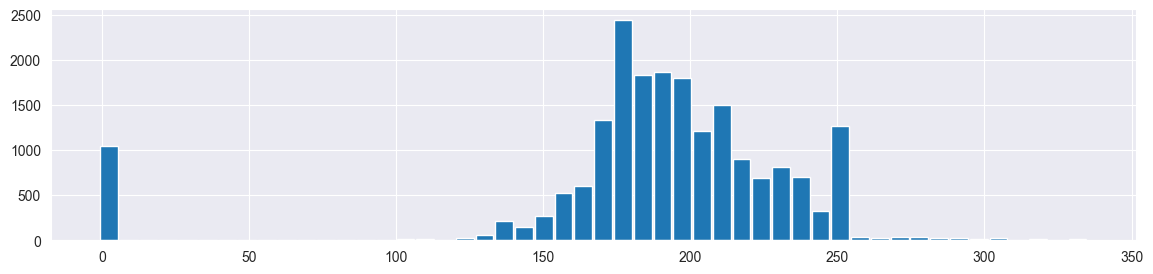

In [18]:
processed_df['max_speed'] = df.max_speed
processed_df.max_speed.hist(bins=50, rwidth=0.9)

#### Разгон до 100

<Axes: >

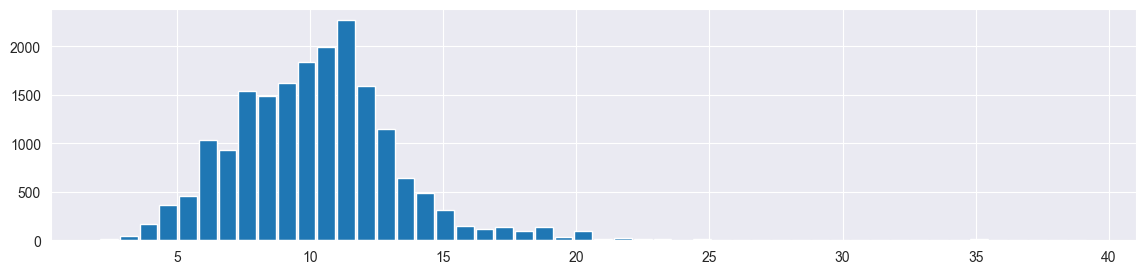

In [19]:
processed_df['zero_to_100'] = df.zero_to_100
processed_df.zero_to_100.hist(bins=50, rwidth=0.9)

#### Смешанный расход топлива

<Axes: >

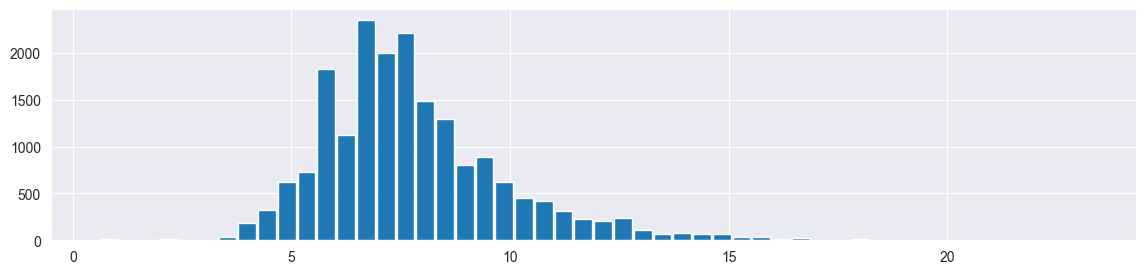

In [20]:
processed_df['fuel_consumption_mixed'] = df.fuel_consumption_mixed
processed_df.fuel_consumption_mixed.hist(bins=50, rwidth=0.9)

#### Объём двигателя

<Axes: >

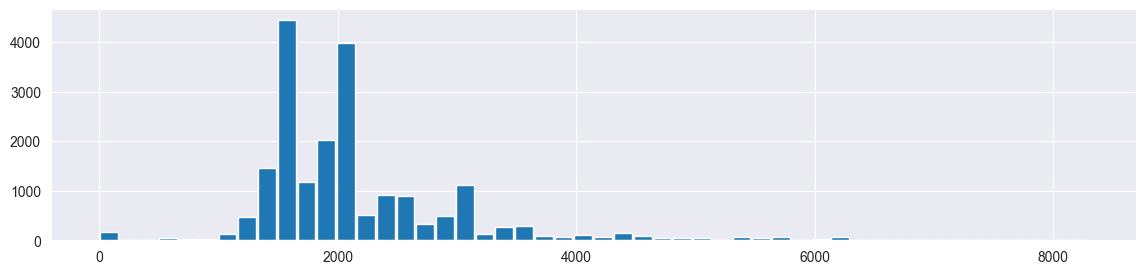

In [21]:
processed_df['engine_displacement'] = df.engine_displacement
processed_df.engine_displacement.hist(bins=50, rwidth=0.9)

#### Мощность двигателя

<Axes: >

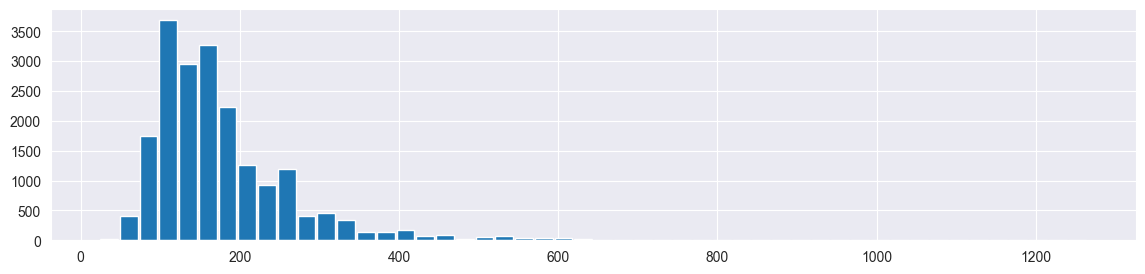

In [22]:
processed_df['engine_max_horsepower'] = df.engine_max_horsepower
processed_df.engine_max_horsepower.hist(bins=50, rwidth=0.9)

#### Крутящий момент двигателя

<Axes: >

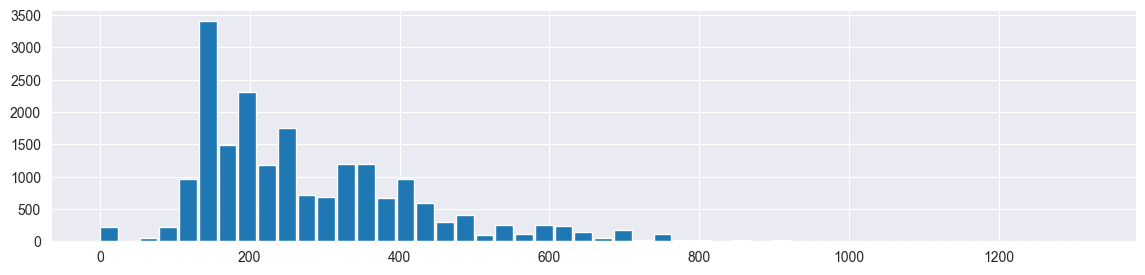

In [23]:
processed_df['engine_max_torque'] = df.engine_max_torque
processed_df.engine_max_torque.hist(bins=50, rwidth=0.9)

#### Количество цилиндров в двигателе

<Axes: >

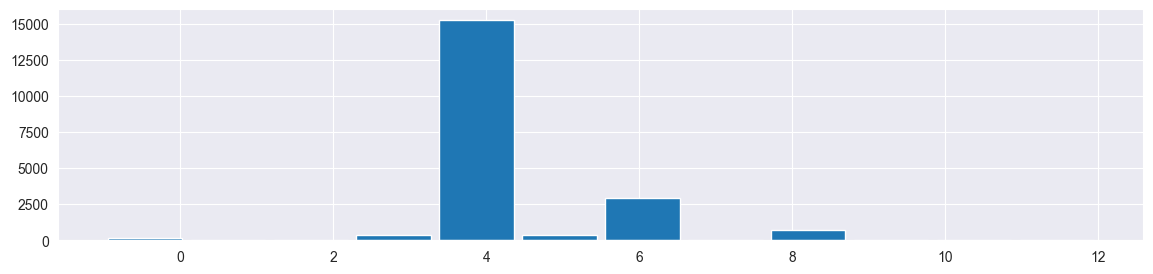

In [24]:
processed_df['engine_cylinders_count'] = df.engine_cylinders_count
processed_df.engine_cylinders_count.hist(bins=12, rwidth=0.9)

#### Средняя цена

<Axes: >

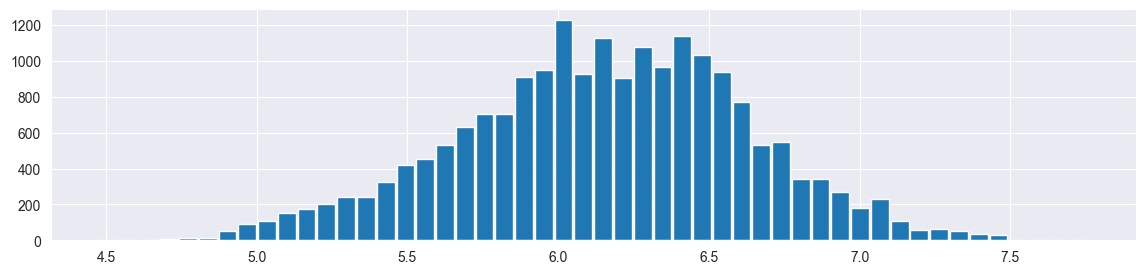

In [25]:
processed_df['price_avg'] = price_log
processed_df.price_avg.hist(bins=50, rwidth=0.9)

### Target

#### Тип привода

Тут хотим сделать label encoding, чтобы сделать из этого признака target. Хорошо ложится на kNN, где не бывает промежуточных значений результата

In [26]:
le = LabelEncoder()
le.fit(df.drive_type)
le.classes_

array(['задний', 'передний', 'полный'], dtype=object)

In [27]:
processed_df['target'] = le.transform(df.drive_type)
processed_df

,doors_count,seats_count,length,width,height,wheelbase,clearance,front_track,rear_track,max_speed,zero_to_100,fuel_consumption_mixed,engine_displacement,engine_max_horsepower,engine_max_torque,engine_cylinders_count,price_avg,target
1,4,5,4860,1720,1425,2735,145,1440,1450,-1,NaN,9.0,2495,190,235,6,5.361728,0
9,4,5,4860,1720,1425,2735,145,1440,1450,-1,NaN,NaN,2825,100,181,6,5.913814,0
60,4,5,4865,1770,1180,2800,140,1510,1510,251,6.8,11.0,2960,280,387,6,5.707570,0
63,4,5,4865,1770,1180,2800,140,1510,1510,245,6.6,11.0,2960,280,387,6,5.707570,0
64,4,5,4865,1770,1180,2800,140,1510,1510,180,8.8,8.5,2495,210,265,6,5.791691,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58264,4,5,4630,1760,1480,2700,150,1505,1510,185,11.6,7.7,1794,129,170,4,5.778151,1
58266,4,5,4630,1760,1480,2700,150,1505,1510,205,9.4,8.0,1998,147,196,4,5.785330,1
58267,4,5,4630,1760,1480,2700,150,1505,1510,195,11.1,9.2,1998,147,196,4,5.785330,1
58268,4,5,4630,1760,1480,2700,150,1505,1510,200,10.3,7.2,1794,129,170,4,5.778151,1


### Категориальные признаки

In [28]:
processed_df

,doors_count,seats_count,length,width,height,wheelbase,clearance,front_track,rear_track,max_speed,zero_to_100,fuel_consumption_mixed,engine_displacement,engine_max_horsepower,engine_max_torque,engine_cylinders_count,price_avg,target
1,4,5,4860,1720,1425,2735,145,1440,1450,-1,NaN,9.0,2495,190,235,6,5.361728,0
9,4,5,4860,1720,1425,2735,145,1440,1450,-1,NaN,NaN,2825,100,181,6,5.913814,0
60,4,5,4865,1770,1180,2800,140,1510,1510,251,6.8,11.0,2960,280,387,6,5.707570,0
63,4,5,4865,1770,1180,2800,140,1510,1510,245,6.6,11.0,2960,280,387,6,5.707570,0
64,4,5,4865,1770,1180,2800,140,1510,1510,180,8.8,8.5,2495,210,265,6,5.791691,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58264,4,5,4630,1760,1480,2700,150,1505,1510,185,11.6,7.7,1794,129,170,4,5.778151,1
58266,4,5,4630,1760,1480,2700,150,1505,1510,205,9.4,8.0,1998,147,196,4,5.785330,1
58267,4,5,4630,1760,1480,2700,150,1505,1510,195,11.1,9.2,1998,147,196,4,5.785330,1
58268,4,5,4630,1760,1480,2700,150,1505,1510,200,10.3,7.2,1794,129,170,4,5.778151,1


#### Класс

In [29]:
processed_df = processed_df.join(pd.get_dummies(df.classe, prefix="classe"))
processed_df = processed_df[processed_df.classe_undefined == False]
processed_df = processed_df.drop('classe_undefined', axis=1)
processed_df

,doors_count,seats_count,length,width,height,wheelbase,clearance,front_track,rear_track,max_speed,...,target,classe_A,classe_B,classe_C,classe_D,classe_E,classe_F,classe_J,classe_M,classe_S
1,4,5,4860,1720,1425,2735,145,1440,1450,-1,...,0,False,False,False,False,True,False,False,False,False
9,4,5,4860,1720,1425,2735,145,1440,1450,-1,...,0,False,False,False,False,True,False,False,False,False
60,4,5,4865,1770,1180,2800,140,1510,1510,251,...,0,False,False,False,False,True,False,False,False,False
63,4,5,4865,1770,1180,2800,140,1510,1510,245,...,0,False,False,False,False,True,False,False,False,False
64,4,5,4865,1770,1180,2800,140,1510,1510,180,...,0,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58264,4,5,4630,1760,1480,2700,150,1505,1510,185,...,1,False,False,False,True,False,False,False,False,False
58266,4,5,4630,1760,1480,2700,150,1505,1510,205,...,1,False,False,False,True,False,False,False,False,False
58267,4,5,4630,1760,1480,2700,150,1505,1510,195,...,1,False,False,False,True,False,False,False,False,False
58268,4,5,4630,1760,1480,2700,150,1505,1510,200,...,1,False,False,False,True,False,False,False,False,False


#### Тип кузова

In [30]:
df.body_type = df.body_type.apply(lambda x: x.split()[0].strip())
processed_df = processed_df.join(pd.get_dummies(df.body_type, prefix="body_type"))
processed_df

C:\Users\btima\AppData\Local\Temp\ipykernel_79340\3598234286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.body_type = df.body_type.apply(lambda x: x.split()[0].strip())


,doors_count,seats_count,length,width,height,wheelbase,clearance,front_track,rear_track,max_speed,...,body_type_Микровэн,body_type_Минивэн,body_type_Пикап,body_type_Родстер,body_type_Седан,body_type_Седан-хардтоп,body_type_Тарга,body_type_Универсал,body_type_Фургон,body_type_Хэтчбек
1,4,5,4860,1720,1425,2735,145,1440,1450,-1,...,False,False,False,False,True,False,False,False,False,False
9,4,5,4860,1720,1425,2735,145,1440,1450,-1,...,False,False,False,False,True,False,False,False,False,False
60,4,5,4865,1770,1180,2800,140,1510,1510,251,...,False,False,False,False,True,False,False,False,False,False
63,4,5,4865,1770,1180,2800,140,1510,1510,245,...,False,False,False,False,True,False,False,False,False,False
64,4,5,4865,1770,1180,2800,140,1510,1510,180,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58264,4,5,4630,1760,1480,2700,150,1505,1510,185,...,False,False,False,False,True,False,False,False,False,False
58266,4,5,4630,1760,1480,2700,150,1505,1510,205,...,False,False,False,False,True,False,False,False,False,False
58267,4,5,4630,1760,1480,2700,150,1505,1510,195,...,False,False,False,False,True,False,False,False,False,False
58268,4,5,4630,1760,1480,2700,150,1505,1510,200,...,False,False,False,False,True,False,False,False,False,False


#### Тип двигателя

In [31]:
processed_df = processed_df.join(pd.get_dummies(df.engine_type, prefix="engine_type"))
processed_df

,doors_count,seats_count,length,width,height,wheelbase,clearance,front_track,rear_track,max_speed,...,body_type_Седан-хардтоп,body_type_Тарга,body_type_Универсал,body_type_Фургон,body_type_Хэтчбек,engine_type_ГБО,engine_type_Электро,engine_type_бензиновый,engine_type_гибридный,engine_type_дизельный
1,4,5,4860,1720,1425,2735,145,1440,1450,-1,...,False,False,False,False,False,False,False,True,False,False
9,4,5,4860,1720,1425,2735,145,1440,1450,-1,...,False,False,False,False,False,False,False,False,False,True
60,4,5,4865,1770,1180,2800,140,1510,1510,251,...,False,False,False,False,False,False,False,True,False,False
63,4,5,4865,1770,1180,2800,140,1510,1510,245,...,False,False,False,False,False,False,False,True,False,False
64,4,5,4865,1770,1180,2800,140,1510,1510,180,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58264,4,5,4630,1760,1480,2700,150,1505,1510,185,...,False,False,False,False,False,False,False,True,False,False
58266,4,5,4630,1760,1480,2700,150,1505,1510,205,...,False,False,False,False,False,False,False,True,False,False
58267,4,5,4630,1760,1480,2700,150,1505,1510,195,...,False,False,False,False,False,False,False,True,False,False
58268,4,5,4630,1760,1480,2700,150,1505,1510,200,...,False,False,False,False,False,False,False,True,False,False


55 сырых признаков превратились в 51 потенциально полезных.... 

Ллладно..

### Обрезание хвостов

In [32]:
processed_df = processed_df[(3500 <= processed_df.length) & (processed_df.length <= 5400) &
                            (1590 <= processed_df.width) & (processed_df.width <= 2100) &
                            (1300 <= processed_df.height) & (processed_df.height <= 2000) &
                            (2300 <= processed_df.wheelbase) & (processed_df.wheelbase <= 3400) &
                            (90 <= processed_df.clearance) & (processed_df.clearance <= 260) &
                            (1280 <= processed_df.front_track) & (processed_df.front_track <= 1970) &
                            (1250 <= processed_df.rear_track) & (processed_df.rear_track <= 1790) &
                            (100 <= processed_df.max_speed) & (processed_df.max_speed <= 300) &
                            (1.8 <= processed_df.zero_to_100) & (processed_df.zero_to_100 <= 25.) &
                            (3 <= processed_df.fuel_consumption_mixed) & (processed_df.fuel_consumption_mixed <= 18) &
                            (500 <= processed_df.engine_displacement) & (processed_df.engine_displacement <= 6250) &
                            (0 < processed_df.engine_max_horsepower) & (processed_df.engine_max_horsepower <= 620) &
                            (0 < processed_df.engine_max_torque) & (processed_df.engine_max_torque <= 800) &
                            (0 < processed_df.engine_cylinders_count) &
                            (5 <= processed_df.price_avg) & (processed_df.price_avg <= 7)]
processed_df

,doors_count,seats_count,length,width,height,wheelbase,clearance,front_track,rear_track,max_speed,...,body_type_Седан-хардтоп,body_type_Тарга,body_type_Универсал,body_type_Фургон,body_type_Хэтчбек,engine_type_ГБО,engine_type_Электро,engine_type_бензиновый,engine_type_гибридный,engine_type_дизельный
70,5,5,4394,1781,1722,2619,200,1554,1550,190,...,False,False,False,False,False,False,False,True,False,False
71,5,5,4394,1781,1722,2619,200,1554,1550,171,...,False,False,False,False,False,False,False,True,False,False
74,5,5,4394,1781,1722,2619,200,1554,1550,188,...,False,False,False,False,False,False,False,True,False,False
117,4,6,4782,1904,1940,3098,164,1615,1630,155,...,False,False,False,False,False,False,False,False,False,True
118,4,6,4782,1904,1940,3098,164,1615,1630,155,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58263,4,5,4630,1760,1480,2700,150,1505,1510,220,...,False,False,False,False,False,False,False,True,False,False
58264,4,5,4630,1760,1480,2700,150,1505,1510,185,...,False,False,False,False,False,False,False,True,False,False
58266,4,5,4630,1760,1480,2700,150,1505,1510,205,...,False,False,False,False,False,False,False,True,False,False
58267,4,5,4630,1760,1480,2700,150,1505,1510,195,...,False,False,False,False,False,False,False,True,False,False


#### Удаление категориальных признаков, которые всюду False

In [33]:
bool_cols = ~processed_df.any(bool_only=True)
only_falses = bool_cols[bool_cols]
cols_only_falses = only_falses.index.to_list()
processed_df = processed_df.drop(cols_only_falses, axis=1)

### Численные признаки

#### Количество дверей

<Axes: >

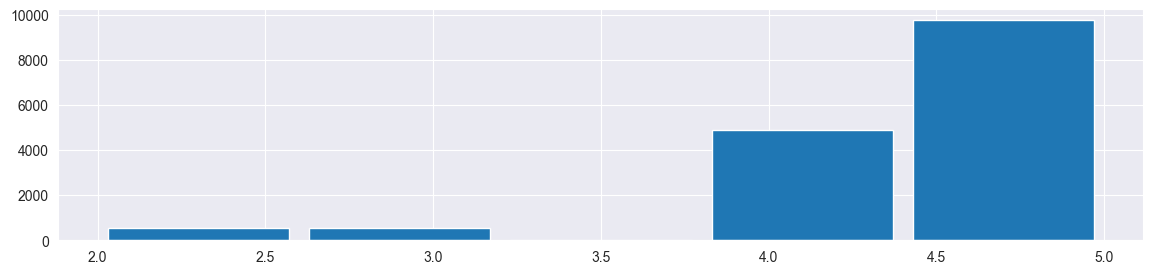

In [34]:
processed_df.doors_count.hist(bins=5, rwidth=0.9)

#### Количество мест

<Axes: >

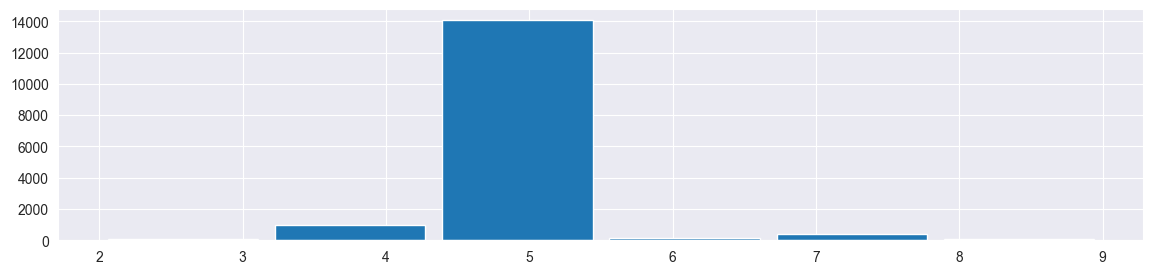

In [35]:
processed_df.seats_count.hist(bins=6, rwidth=0.9)

#### Длина

<Axes: >

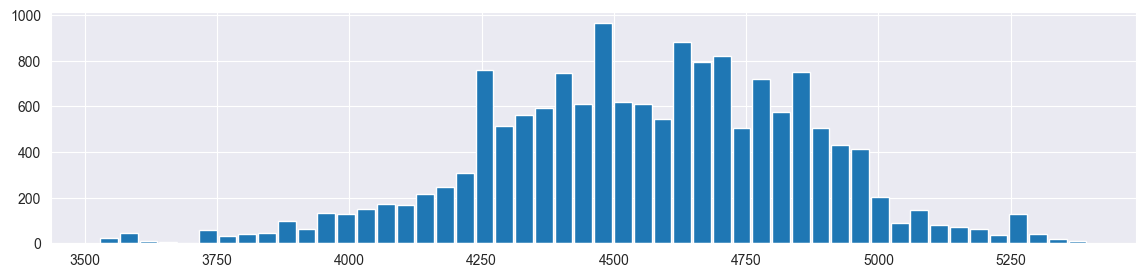

In [36]:
processed_df.length.hist(bins=50, rwidth=0.9)

#### Ширина

<Axes: >

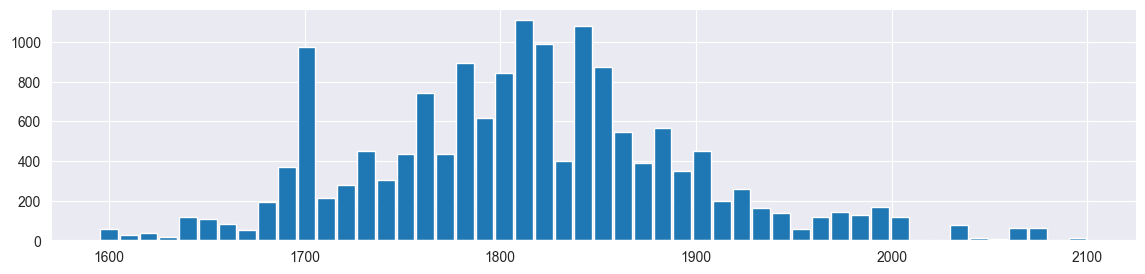

In [37]:
processed_df.width.hist(bins=50, rwidth=0.9)

#### Высота

<Axes: >

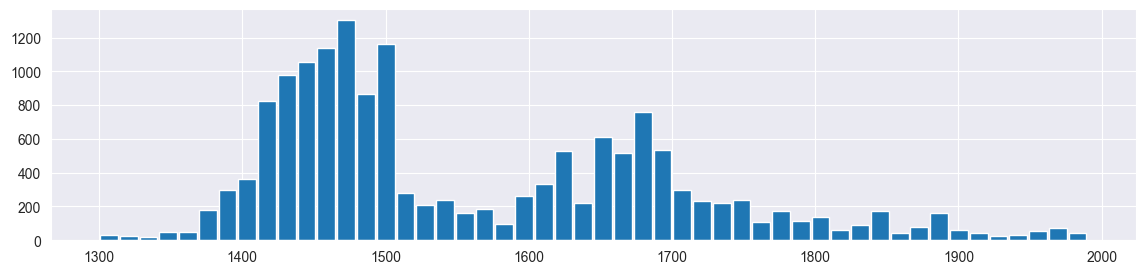

In [38]:
processed_df.height.hist(bins=50, rwidth=0.9)

#### Колёсная база

<Axes: >

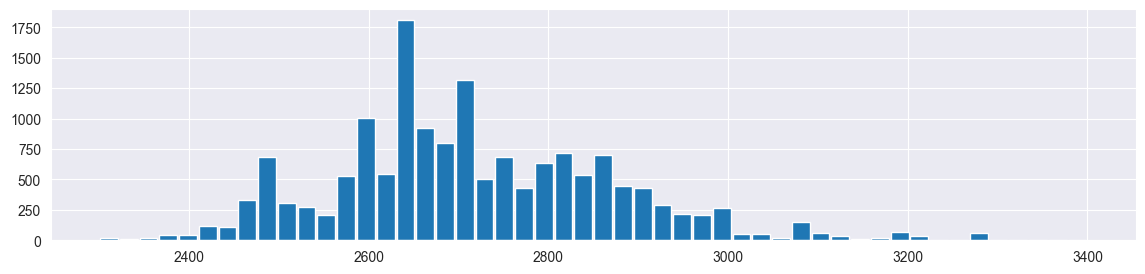

In [39]:
processed_df.wheelbase.hist(bins=50, rwidth=0.9)

#### Клиренс

<Axes: >

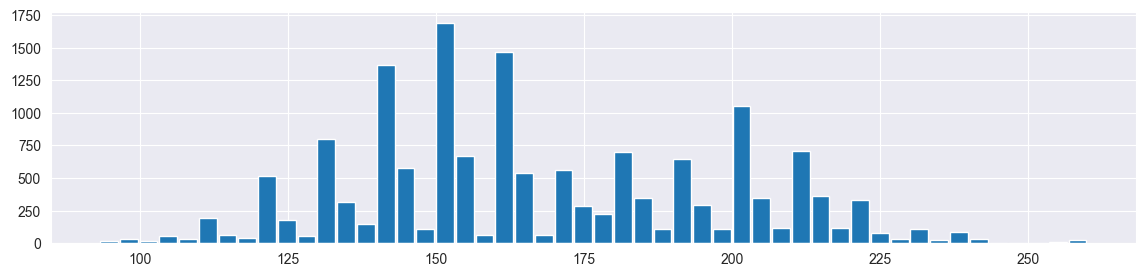

In [40]:
processed_df.clearance.hist(bins=50, rwidth=0.9)

#### Передняя колея

<Axes: >

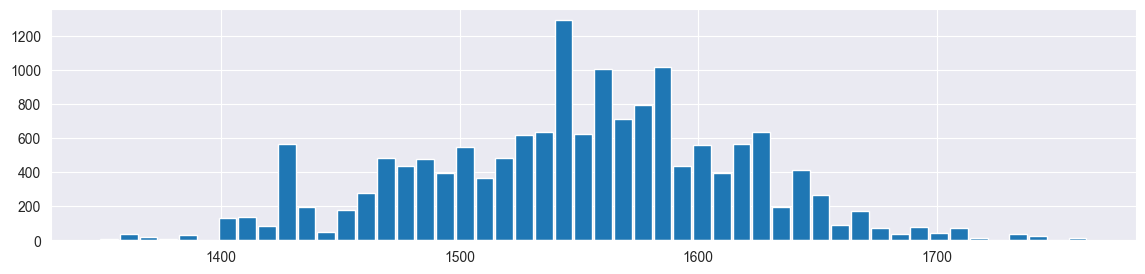

In [41]:
processed_df.front_track.hist(bins=50, rwidth=0.9)

#### Задняя колея

<Axes: >

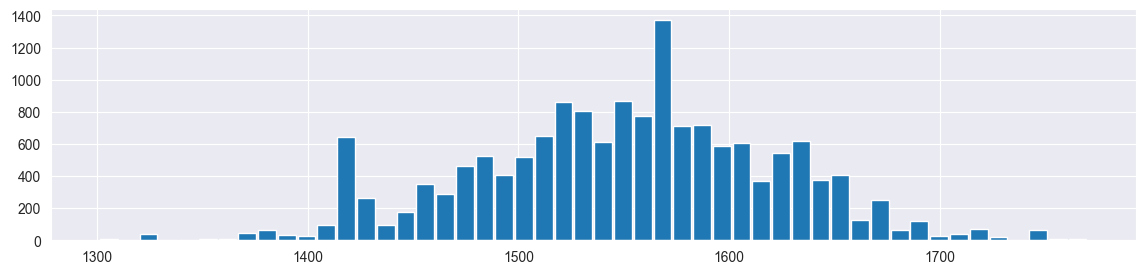

In [42]:
processed_df.rear_track.hist(bins=50, rwidth=0.9)

#### Максимальная скорость

<Axes: >

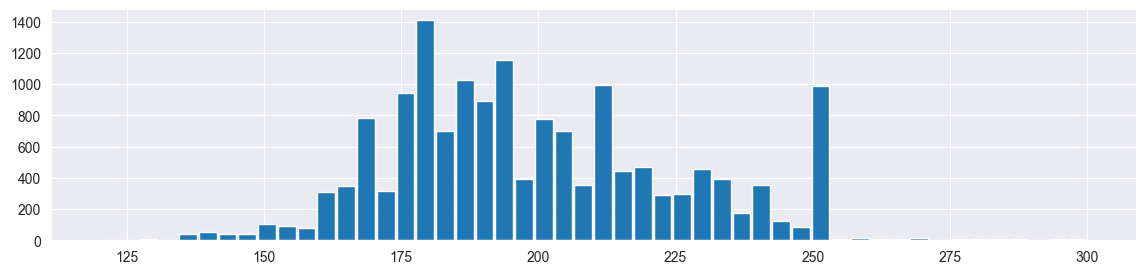

In [43]:
processed_df.max_speed.hist(bins=50, rwidth=0.9)

#### Разгон до 100

<Axes: >

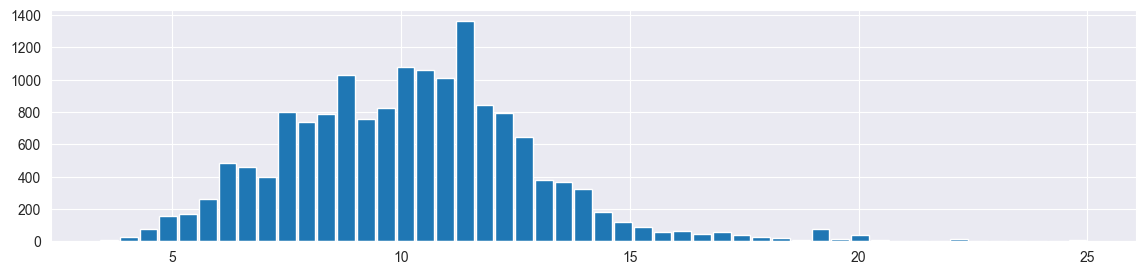

In [44]:
processed_df.zero_to_100.hist(bins=50, rwidth=0.9)

#### Смешанный расход топлива

<Axes: >

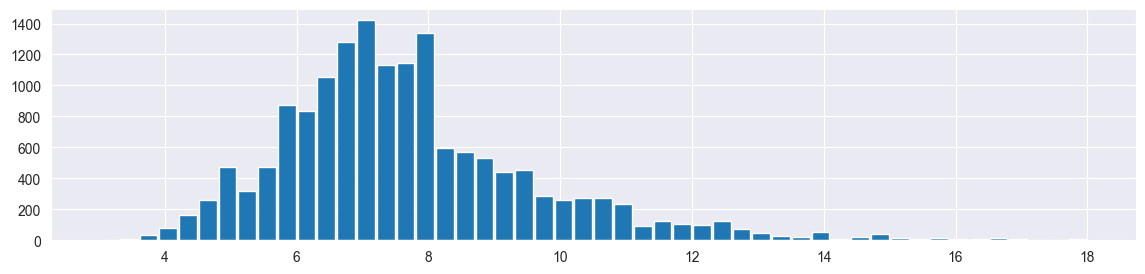

In [45]:
processed_df.fuel_consumption_mixed.hist(bins=50, rwidth=0.9)

#### Объём двигателя

<Axes: >

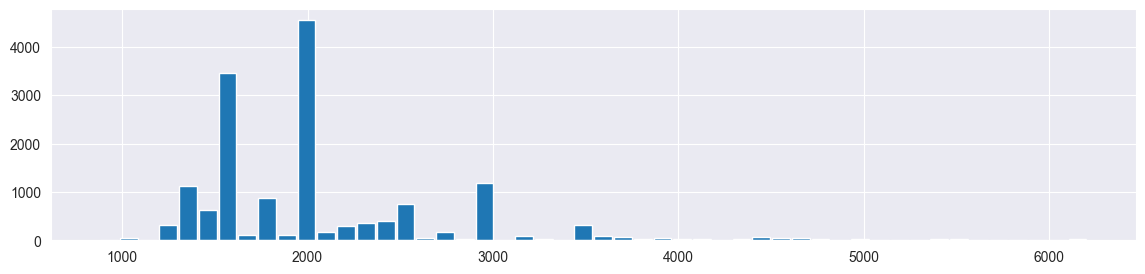

In [46]:
processed_df.engine_displacement.hist(bins=50, rwidth=0.9)

#### Мощность двигателя

<Axes: >

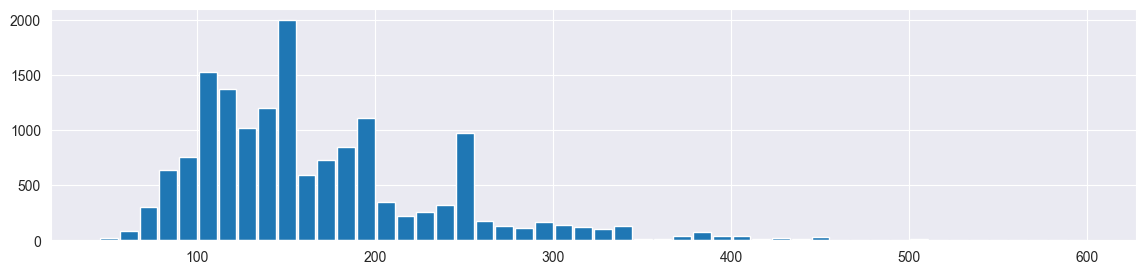

In [47]:
processed_df.engine_max_horsepower.hist(bins=50, rwidth=0.9)

#### Крутящий момент двигателя

<Axes: >

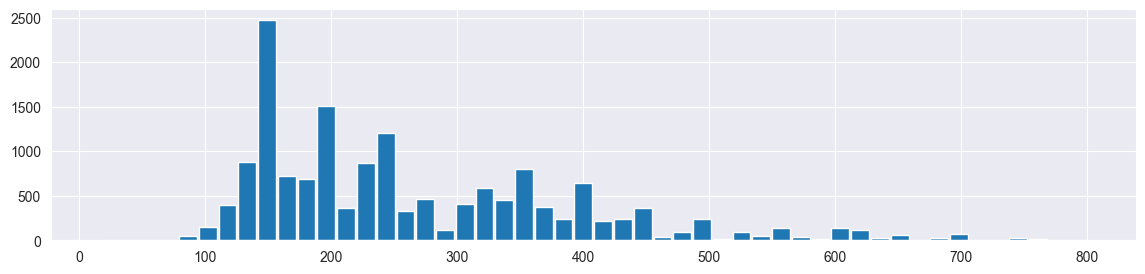

In [48]:
processed_df.engine_max_torque.hist(bins=50, rwidth=0.9)

#### Количество цилиндров в двигателе

<Axes: >

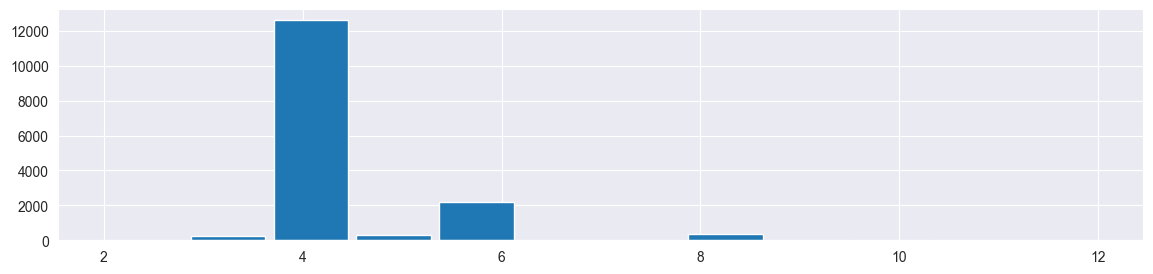

In [49]:
processed_df.engine_cylinders_count.hist(bins=12, rwidth=0.9)

#### Средняя цена

<Axes: >

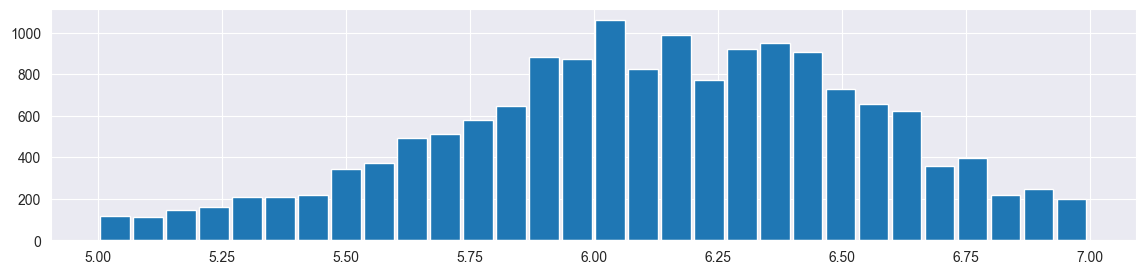

In [50]:
processed_df.price_avg.hist(bins=30, rwidth=0.9)

### Коррелограмма

In [51]:
mc.MoveToLast(processed_df, 'target')

,doors_count,seats_count,length,width,height,wheelbase,clearance,front_track,rear_track,max_speed,...,body_type_Родстер,body_type_Седан,body_type_Универсал,body_type_Фургон,body_type_Хэтчбек,engine_type_ГБО,engine_type_бензиновый,engine_type_гибридный,engine_type_дизельный,target
70,5,5,4394,1781,1722,2619,200,1554,1550,190,...,False,False,False,False,False,False,True,False,False,2
71,5,5,4394,1781,1722,2619,200,1554,1550,171,...,False,False,False,False,False,False,True,False,False,2
74,5,5,4394,1781,1722,2619,200,1554,1550,188,...,False,False,False,False,False,False,True,False,False,2
117,4,6,4782,1904,1940,3098,164,1615,1630,155,...,False,False,False,False,False,False,False,False,True,1
118,4,6,4782,1904,1940,3098,164,1615,1630,155,...,False,False,False,False,False,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58263,4,5,4630,1760,1480,2700,150,1505,1510,220,...,False,True,False,False,False,False,True,False,False,1
58264,4,5,4630,1760,1480,2700,150,1505,1510,185,...,False,True,False,False,False,False,True,False,False,1
58266,4,5,4630,1760,1480,2700,150,1505,1510,205,...,False,True,False,False,False,False,True,False,False,1
58267,4,5,4630,1760,1480,2700,150,1505,1510,195,...,False,True,False,False,False,False,True,False,False,1


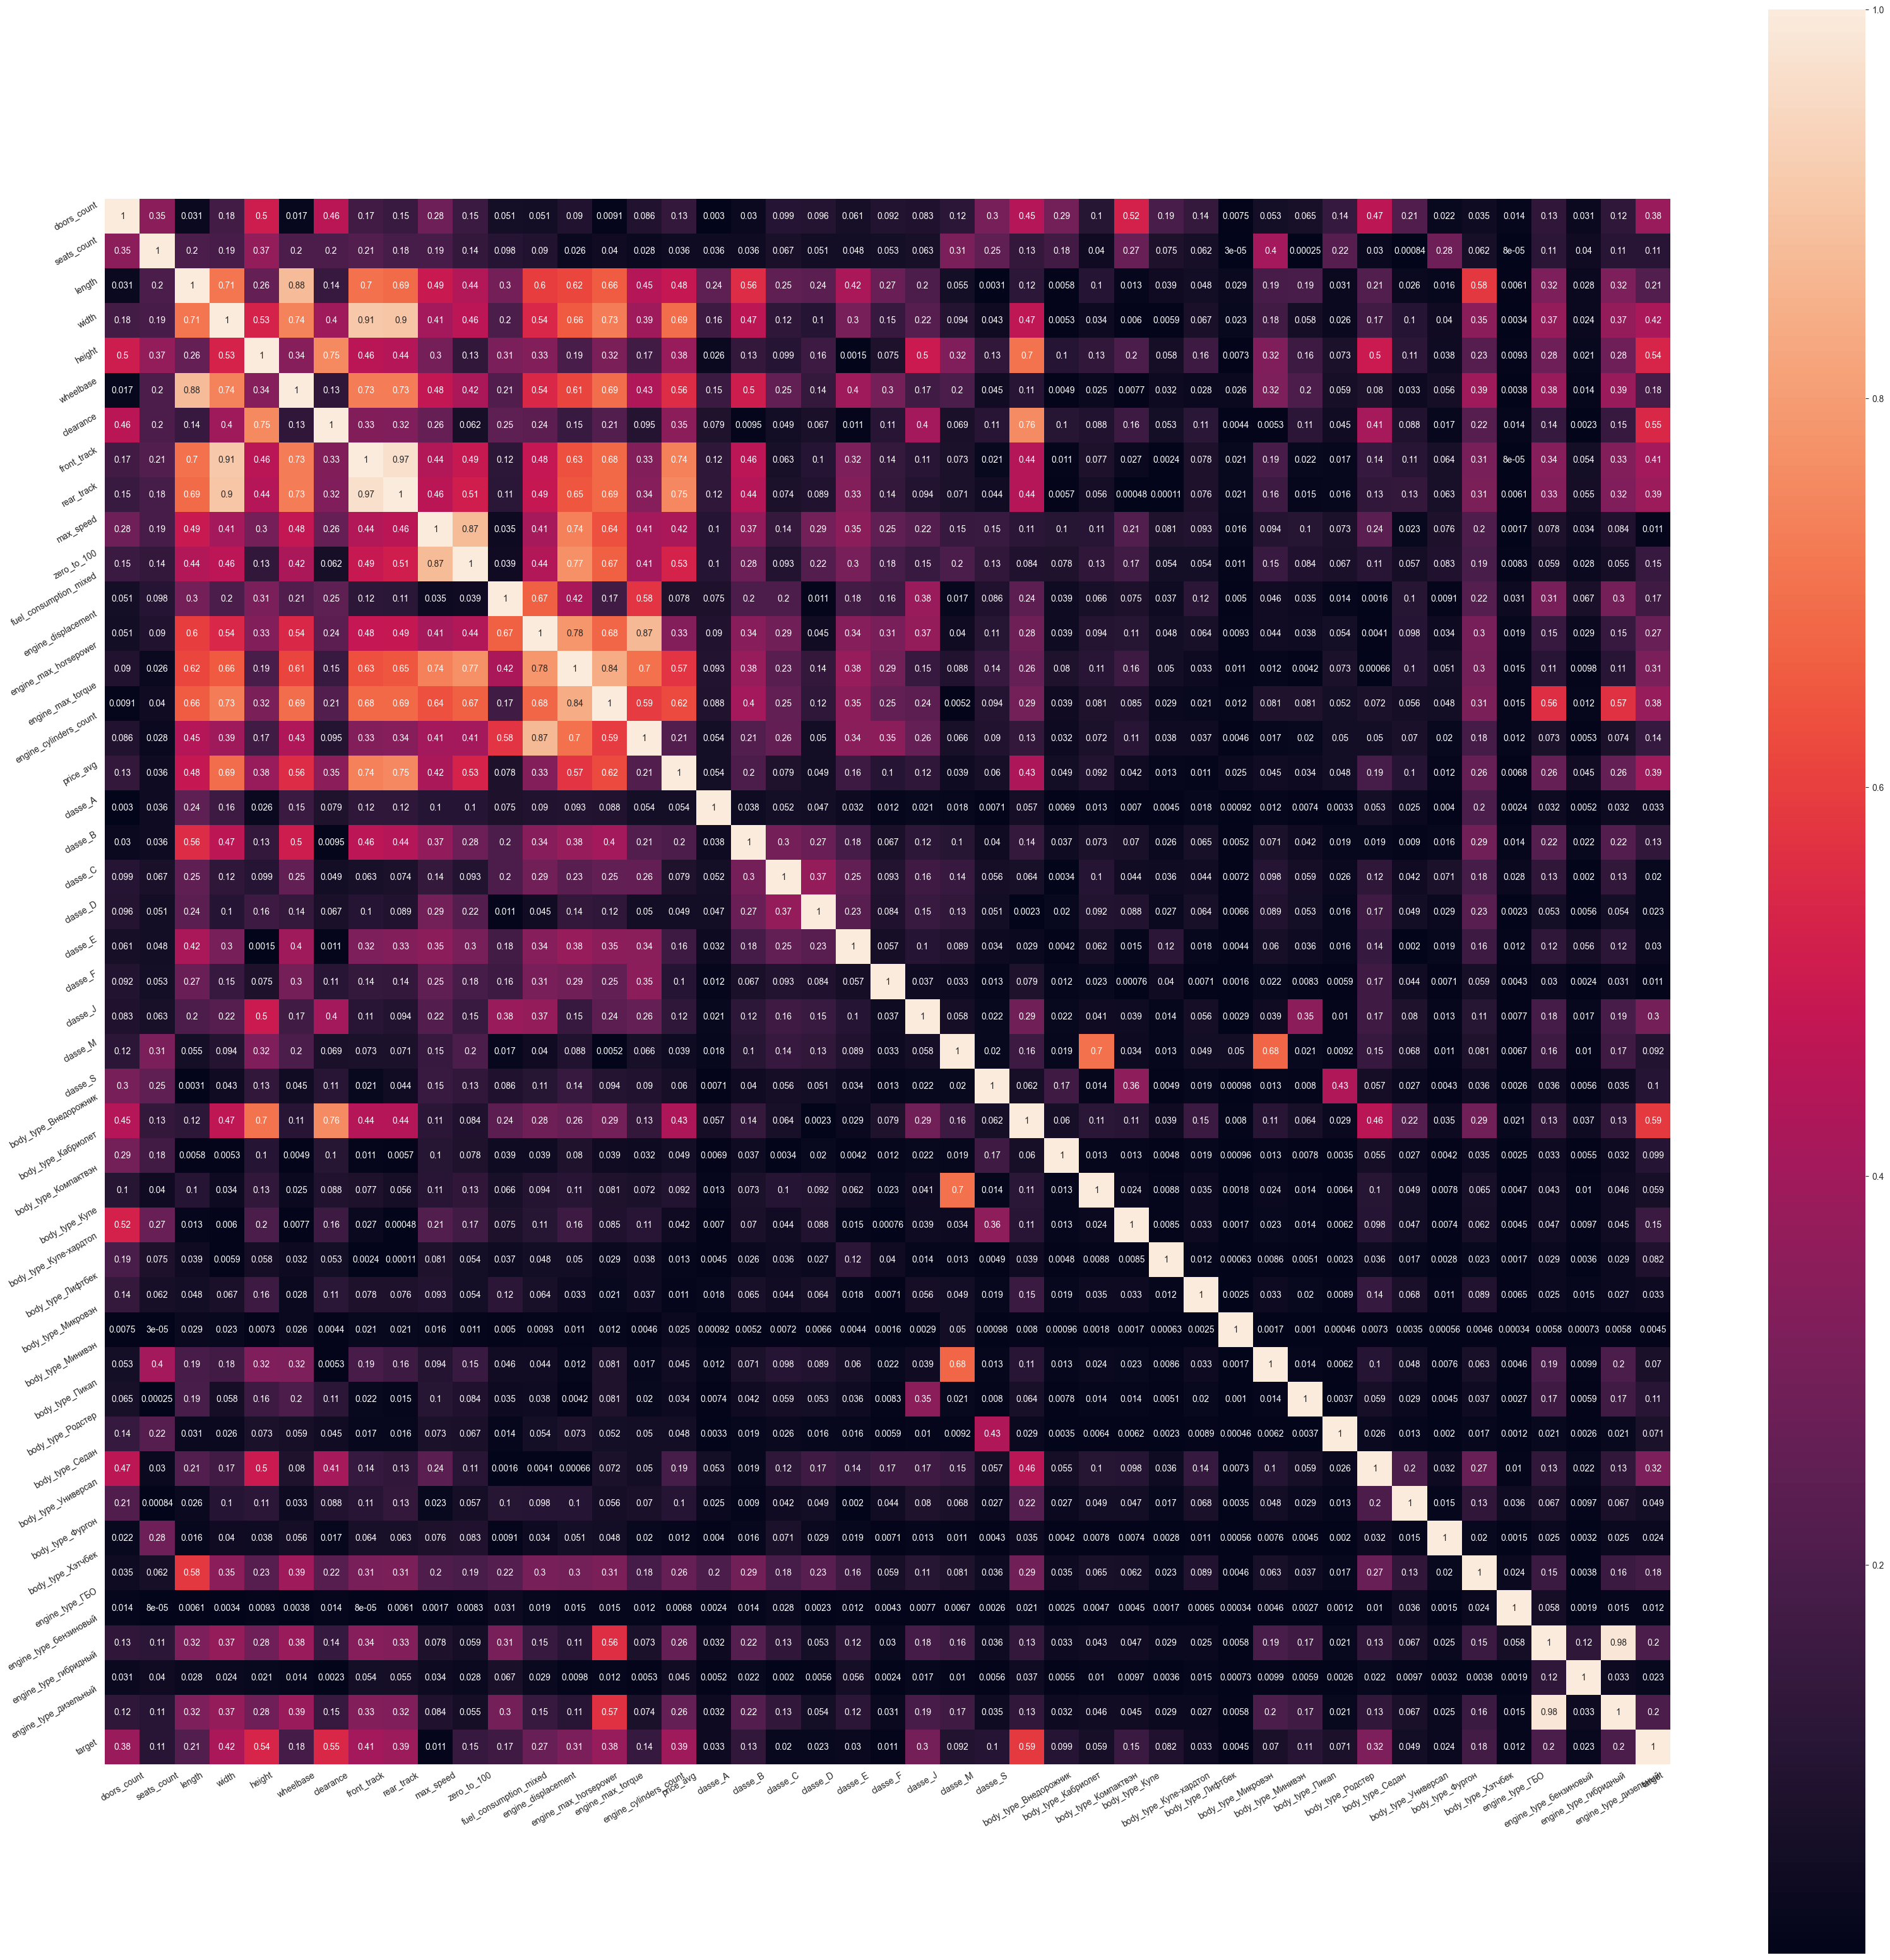

In [52]:
plt.figure(figsize=(40, 40))
sns.heatmap(processed_df.corr().abs(), square=True, linecolor='white', annot=True)
plt.yticks(rotation=30)
plt.xticks(rotation=30)
plt.show()

Штош, смотрим на последнюю строку и видим, что половину фич можно выкинуть к чертям.

Итак, имеет смысл оставить только:
doors_count, width, height, clearance, front_track, rear_track, engine_max_horsepower, engine_max_torque, price_avg, classe_J, body_type_Внедорожник, body_type_Седан

In [53]:
# processed_df = processed_df[["length", "width", "height", "wheelbase", "clearance", "front_track", "rear_track", "max_speed", "zero_to_100", "engine_displacement", "engine_max_horsepower", "engine_max_torque", "engine_cylinders_count", "drive_type_передний", "drive_type_полный", "engine_type_бензиновый", "engine_type_дизельный", "classe_B", "classe_C", "classe_E", "classe_F", "classe_J", "target"]]
# processed_df = processed_df[["length", "width", "height", "wheelbase", "front_track", "rear_track", "max_speed", "zero_to_100", "engine_displacement", "engine_max_horsepower", "engine_max_torque", "engine_cylinders_count", "drive_type_передний", "drive_type_полный", "target"]]
processed_df = processed_df[["doors_count", "width", "height", "clearance", "front_track", "rear_track", "engine_max_horsepower", "engine_max_torque", "price_avg", "classe_J", "body_type_Внедорожник", "body_type_Седан", "target"]]

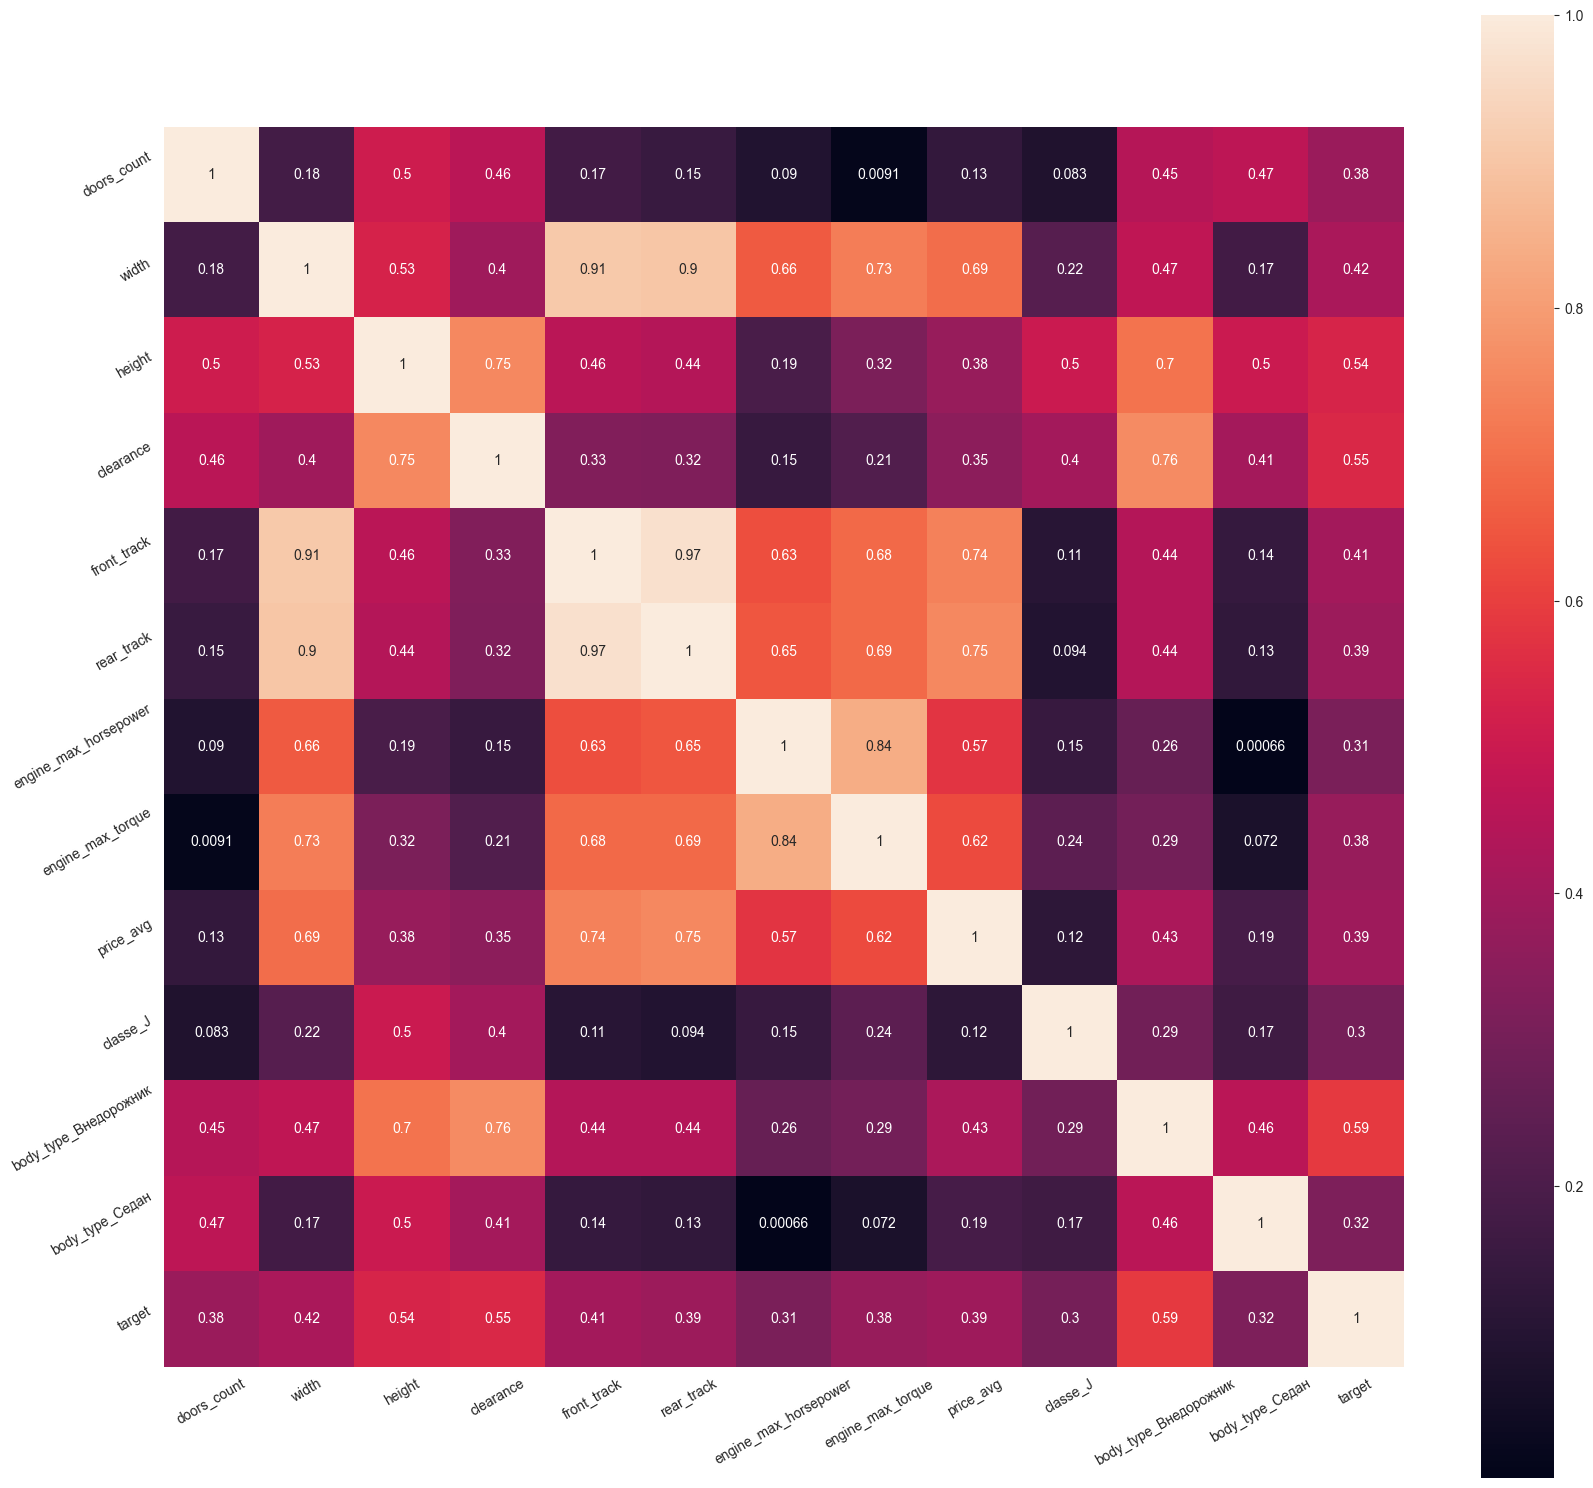

In [54]:
plt.figure(figsize=(20, 19))
sns.heatmap(processed_df.corr().abs(), square=True, linecolor='white', annot=True)
plt.yticks(rotation=30)
plt.xticks(rotation=30)
plt.show()

# Применение моделей

## Разбиение на train, valid, test

In [55]:
x = processed_df.drop('target', axis=1)
y = processed_df['target']
train_features, test_features, train_target, test_target = train_test_split(x, y, test_size=0.66, random_state=0)
test_features, val_features, test_target, val_target = train_test_split(test_features, test_target, test_size=0.5, random_state=0)

print(train_features.shape)
print(train_target.shape)

print(val_features.shape)
print(val_target.shape)

print(test_features.shape)
print(test_target.shape)

(5347, 12)
(5347,)
(5190, 12)
(5190,)
(5190, 12)
(5190,)


## Выбор функции качества

По опыту прошлого семестра чувствую, что здесь с кайфом зайдёт f1 мера

In [56]:
from sklearn.metrics import f1_score, classification_report

In [57]:
def stat_visualize(predictions, test):
    predictions = pd.Series(predictions)
    fig, ax = plt.subplots()
    ax.hist(test, bins=3, fc=(0, 1, 0, 1.0))
    ax.hist(predictions, bins=3, fc=(0, 0, 1, 0.5))

In [58]:
def plot_f1_scores(models, labels, **kwargs):
    f1_scores_train = []
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Вычисление F1-меры для каждой модели
    for model in models:
        y_pred = model.predict(train_features.to_numpy(), **kwargs)
        f1 = f1_score(train_target, y_pred, average='weighted')
        f1_scores_train.append(f1)

    # Построение графика
   
    ax1.plot(labels, f1_scores_train, marker='o', linestyle='-', color='b')
    ax1.set_xlabel("Число соседей")
    ax1.set_ylabel('F1-мера')
    ax1.set_title('Train')
    ax1.set_xticks(labels)
    ax1.grid(True)
    
    f1_scores_test = []
    # Вычисление F1-меры для каждой модели
    for model in models:
        y_pred = model.predict(test_features.to_numpy())
        f1 = f1_score(test_target, y_pred, average='weighted')
        f1_scores_test.append(f1)

    # Построение графика
   
    ax2.plot(labels, f1_scores_test, marker='o', linestyle='-', color='b')
    ax2.set_xlabel("Число соседей")
    ax2.set_ylabel('F1-мера')
    ax2.set_title('Test')
    ax2.set_xticks(labels)
    ax2.grid(True)
    plt.show()


## KNN

C:\Users\btima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\btima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\btima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\btima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\btima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature

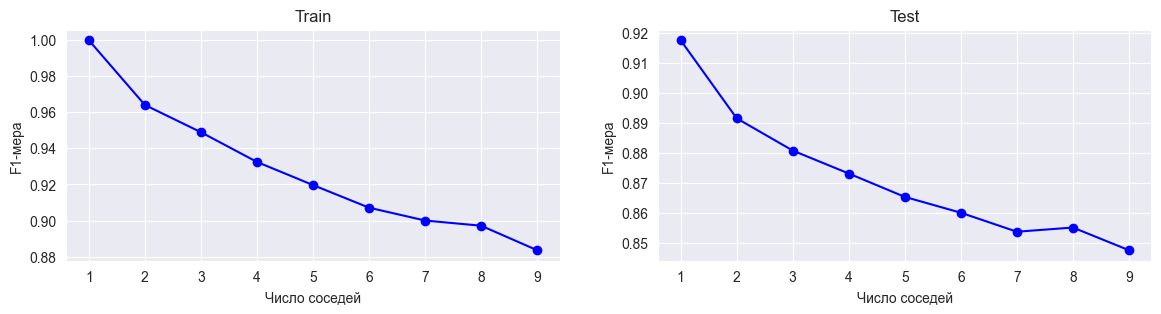

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       559
           1       0.95      0.95      0.95      2805
           2       0.90      0.91      0.91      1826

    accuracy                           0.92      5190
   macro avg       0.89      0.88      0.88      5190
weighted avg       0.92      0.92      0.92      5190


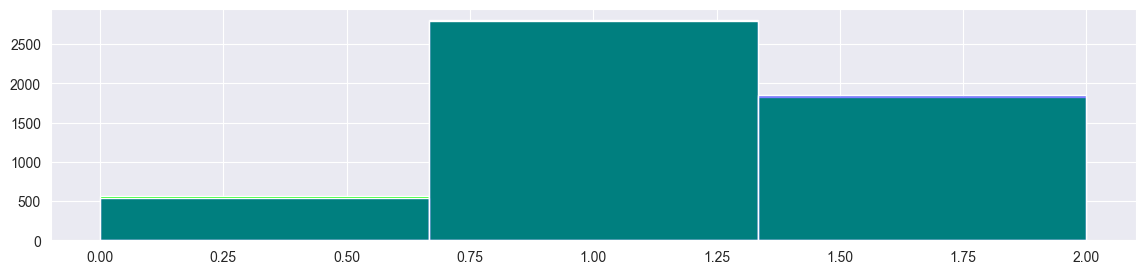

In [59]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestNeighbors

test_neighbors = np.array(range(1, 10))
models = []
for i in test_neighbors:
    models.append(KNeighborsClassifier(n_neighbors=i, metric='euclidean').fit(train_features, train_target))

plot_f1_scores(models, test_neighbors)

print(classification_report(test_target, models[0].predict(test_features)))
stat_visualize(models[0].predict(test_features), test_target)

# DIY KNN

## Разработка метрик

In [60]:
def cosine_distance(x, y):
    return 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

C:\Users\btima\AppData\Local\Temp\ipykernel_79340\1753048625.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


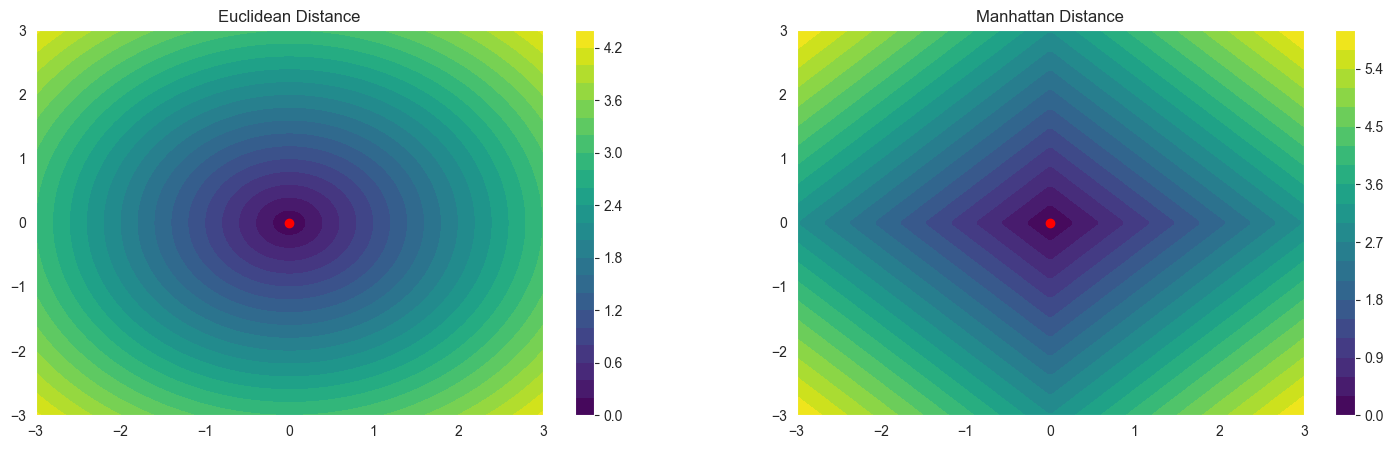

In [61]:
# Визуализация метрик

# Генерация сетки точек
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Расчет расстояний от центра (0, 0)
origin = np.array([0, 0])
cosine_distances_grid = np.array([cosine_distance(origin, point) for point in grid_points]).reshape(xx.shape)
euclidean_distances_grid = np.array([euclidean_distance(origin, point) for point in grid_points]).reshape(xx.shape)
manhattan_distances_grid = np.array([manhattan_distance(origin, point) for point in grid_points]).reshape(xx.shape)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Евклидово расстояние
contour2 = axes[0].contourf(xx, yy, euclidean_distances_grid, levels=20, cmap='viridis')
axes[0].set_title('Euclidean Distance')
axes[0].scatter(0, 0, color='red')  # Центр
fig.colorbar(contour2, ax=axes[0])

# Манхэттенское расстояние
contour3 = axes[1].contourf(xx, yy, manhattan_distances_grid, levels=20, cmap='viridis')
axes[1].set_title('Manhattan Distance')
axes[1].scatter(0, 0, color='red')  # Центр
fig.colorbar(contour3, ax=axes[1])

plt.show()

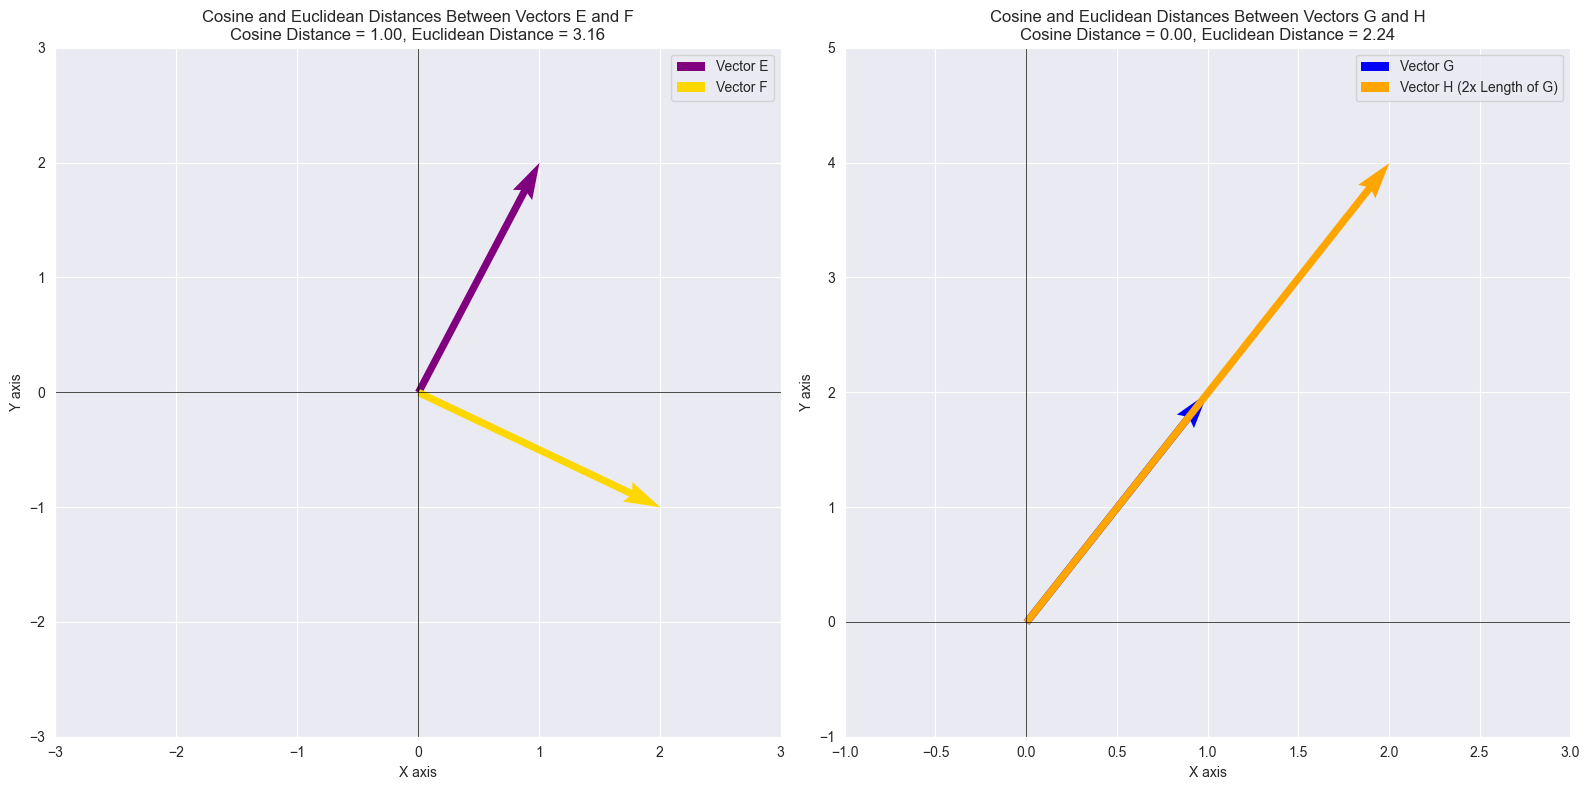

In [62]:
# Векторы для сравнения
vector_e = np.array([1, 2])   # Вектор E
vector_f = np.array([2, -1])  # Вектор F, направленный иначе относительно E
vector_g = np.array([1, 2])   # Вектор G
vector_h = np.array([2, 4])   # Вектор H, в 2 раза длиннее вектора G, но в том же направлении

# Расчет метрик
cosine_ef = 1 - (np.dot(vector_e, vector_f) / (np.linalg.norm(vector_e) * np.linalg.norm(vector_f)))
euclidean_ef = euclidean_distance(vector_e, vector_f)
cosine_gh = 1 - (np.dot(vector_g, vector_h) / (np.linalg.norm(vector_g) * np.linalg.norm(vector_h)))
euclidean_gh = euclidean_distance(vector_g, vector_h)

# Визуализация
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Векторы E и F
ax[0].quiver(0, 0, vector_e[0], vector_e[1], angles='xy', scale_units='xy', scale=1, color='purple', width=0.01, label='Vector E')
ax[0].quiver(0, 0, vector_f[0], vector_f[1], angles='xy', scale_units='xy', scale=1, color='gold', width=0.01, label='Vector F')
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)
ax[0].axhline(0, color='black', linewidth=0.5)
ax[0].axvline(0, color='black', linewidth=0.5)
ax[0].grid(True)
ax[0].legend()
ax[0].set_title(f'Cosine and Euclidean Distances Between Vectors E and F\nCosine Distance = {cosine_ef:.2f}, Euclidean Distance = {euclidean_ef:.2f}')
ax[0].set_xlabel('X axis')
ax[0].set_ylabel('Y axis')

# Векторы G и H
ax[1].quiver(0, 0, vector_g[0], vector_g[1], angles='xy', scale_units='xy', scale=1, color='blue', width=0.01, label='Vector G')
ax[1].quiver(0, 0, vector_h[0], vector_h[1], angles='xy', scale_units='xy', scale=1, color='orange', width=0.01, label='Vector H (2x Length of G)')
ax[1].set_xlim(-1, 3)
ax[1].set_ylim(-1, 5)
ax[1].axhline(0, color='black', linewidth=0.5)
ax[1].axvline(0, color='black', linewidth=0.5)
ax[1].grid(True)
ax[1].legend()
ax[1].set_title(f'Cosine and Euclidean Distances Between Vectors G and H\nCosine Distance = {cosine_gh:.2f}, Euclidean Distance = {euclidean_gh:.2f}')
ax[1].set_xlabel('X axis')
ax[1].set_ylabel('Y axis')

plt.tight_layout()
plt.show()

## Разработка ядер

In [63]:
def uniform_kernel(u):
    return np.array(np.abs(u) < 1, dtype=float) * 0.5

def triangular_kernel(u):
    return np.array(np.abs(u) < 1, dtype=float) * (1 - np.abs(u))

def epanechnikov_kernel(u):
    return np.array(np.abs(u) < 1, dtype=float) * 0.75 * (1 - u ** 2)

def gaussian_kernel(u):
    return np.exp(-0.5 * u ** 2) / np.sqrt(2 * np.pi)

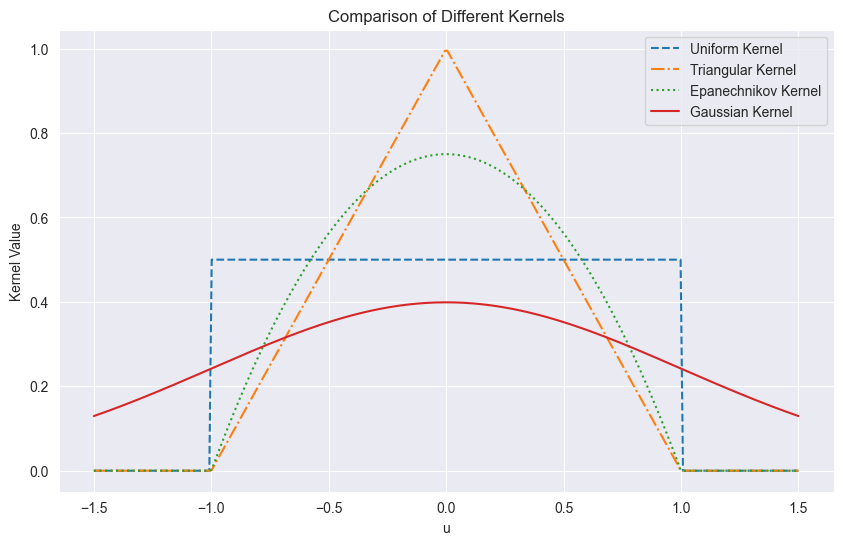

In [64]:
# Генерация значений u
u = np.linspace(-1.5, 1.5, 300)

# Вычисление значений для каждого ядра
uniform_values = uniform_kernel(u)
triangular_values = triangular_kernel(u)
epanechnikov_values = epanechnikov_kernel(u)
gaussian_values = gaussian_kernel(u)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(u, uniform_values, label='Uniform Kernel', linestyle='--')
plt.plot(u, triangular_values, label='Triangular Kernel', linestyle='-.')
plt.plot(u, epanechnikov_values, label='Epanechnikov Kernel', linestyle=':')
plt.plot(u, gaussian_values, label='Gaussian Kernel', linestyle='-')
plt.legend()
plt.title('Comparison of Different Kernels')
plt.xlabel('u')
plt.ylabel('Kernel Value')
plt.grid(True)
plt.show()

## kNN

In [65]:
class KNN:
    """
    Basic KNN implementation
    @param n_neighbors: int, number of neighbors to consider. If window_type is 'fixed', this parameter is ignored
    @param metric: callable, function to calculate distance between two points. accepts two points
    @param kernel: callable, function to calculate weight for each neighbor
    @param window_type: str, type of window to use for distance weighting. Possible values are: 'fixed', 'variable'
    @param window_size: float, size of window to use for distance weighting. If window_type is 'variable', this parameter is ignored
    """
    def __init__(self, n_neighbors=3, metric=euclidean_distance, kernel=uniform_kernel, window_type='fixed', window_size=1.):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.kernel = kernel
        self.window_type = window_type
        self.window_size = window_size
        self.X_train = None
        self.y_train = None
        self.nearest_obj_searcher = None
        self.num_classes = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.nearest_obj_searcher = NearestNeighbors(metric=self.metric)
        self.nearest_obj_searcher.fit(X)
        self.num_classes = len(np.unique(self.y_train))
        return self

    def predict_proba(self, X, to_ignore_first_closest=False, antecedent_weights=None):
        if self.window_type == 'variable':
            # Поиск расстояний до ближайших соседей 
            distances, indices = self.nearest_obj_searcher.kneighbors(X, n_neighbors=self.n_neighbors if not to_ignore_first_closest else self.n_neighbors + 1)
            
            if to_ignore_first_closest:
                distances = distances[:, 1:]
                indices = indices[:, 1:]
            
            window_size = np.max(distances, axis=1) + 0.0000001
            
            labels = self.y_train[indices]
            
            # Вычисление весов с использованием выбранного ядра
            distances_normalized = distances/np.fmax(window_size, 0.0000001)[:,None]
            weights = self.kernel(distances_normalized)

            if antecedent_weights is not None:
                cur_antecedent_weights = antecedent_weights[indices]
                weights *= cur_antecedent_weights
    
            # Агрегация результатов с учетом весов
            weighted_votes = np.zeros((X.shape[0], self.num_classes))
            np.add.at(weighted_votes, (np.arange(labels.shape[0])[:, None], labels), weights)
    
            # Нормализация голосов
            predictions = weighted_votes / np.sum(weighted_votes, axis=1)[:, None]
            
            return predictions
        else:
            # Поиск расстояний до ближайших соседей
            distances, indices = self.nearest_obj_searcher.radius_neighbors(X, radius=self.window_size, sort_results=True)
            window_size = self.window_size
                        
            labels = []
            cur_antecedent_weights = []
            for i in indices:
                if to_ignore_first_closest:
                    i = i[1:]
                if antecedent_weights is not None:
                    cur_antecedent_weights.append(antecedent_weights[i])
                labels.append(self.y_train[i])
            
            # Вычисление весов с использованием выбранного ядра
            distances_normalized = distances/window_size
            weights = []
            for i in distances_normalized:
                if to_ignore_first_closest:
                    if len(i) == 0 or i[0] > 0.0000000001:
                        raise ValueError("to_ignore_first_closest can only be used with train dataset")
                    i = i[1:]
                weights.append(self.kernel(i))
            
            # Агрегация результатов с учетом весов
            weighted_votes = []
            if antecedent_weights is None:
                for label, weight in zip(labels, weights):
                    aggregate = np.zeros(self.num_classes)
                    np.add.at(aggregate, label, weight)
                    weighted_votes.append(aggregate)
            else:
                for label, weight, antecedent_weight in zip(labels, weights, cur_antecedent_weights):
                    aggregate = np.zeros(self.num_classes)
                    np.add.at(aggregate, label, weight * antecedent_weight)
                    weighted_votes.append(aggregate)
            weighted_votes = np.array(weighted_votes)
            
            # Нормализация голосов
            predictions = weighted_votes / np.fmax(np.sum(weighted_votes, axis=1)[:, None], 0.0000001)
            
            return predictions
    
    def predict(self, X, antecedent_weights=None):
        predictions = self.predict_proba(X, antecedent_weights=antecedent_weights)
        # Предсказание класса с максимальным взвешенным голосом
        result = np.argmax(predictions, axis=1)
        return result

# Демонстрация работы

## Euclidean distance + uniform kernel + variable window

              precision    recall  f1-score   support

           0       0.70      0.86      0.77       559
           1       0.91      0.94      0.93      2805
           2       0.93      0.82      0.87      1826

    accuracy                           0.89      5190
   macro avg       0.85      0.87      0.86      5190
weighted avg       0.90      0.89      0.89      5190


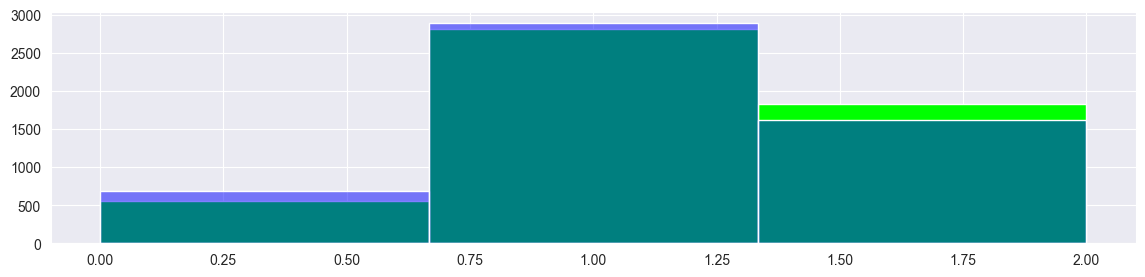

In [66]:
model = KNN(n_neighbors=2, metric=euclidean_distance, kernel=uniform_kernel, window_type="variable", window_size=1.).fit(train_features.to_numpy(), train_target.to_numpy())
predictions = model.predict(test_features.to_numpy())

print(classification_report(test_target, predictions))
stat_visualize(predictions, test_target)

## Euclidean distance + triangular kernel + variable window

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       559
           1       0.95      0.95      0.95      2805
           2       0.90      0.91      0.91      1826

    accuracy                           0.92      5190
   macro avg       0.89      0.88      0.88      5190
weighted avg       0.92      0.92      0.92      5190


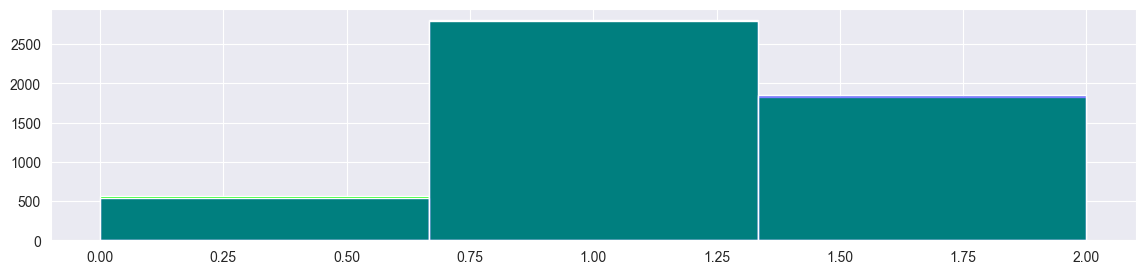

In [67]:
model = KNN(n_neighbors=2, metric=euclidean_distance, kernel=triangular_kernel, window_type="variable", window_size=1.).fit(train_features.to_numpy(), train_target.to_numpy())
predictions = model.predict(test_features.to_numpy())

print(classification_report(test_target, predictions))
stat_visualize(predictions, test_target)

## Euclidean distance + epanechnikov kernel + variable window

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       559
           1       0.95      0.95      0.95      2805
           2       0.90      0.91      0.91      1826

    accuracy                           0.92      5190
   macro avg       0.89      0.88      0.88      5190
weighted avg       0.92      0.92      0.92      5190


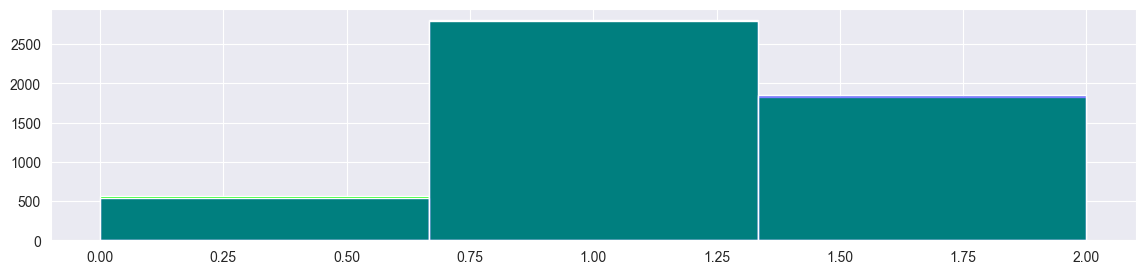

In [68]:
model = KNN(n_neighbors=2, metric=euclidean_distance, kernel=epanechnikov_kernel, window_type="variable", window_size=1.).fit(train_features.to_numpy(), train_target.to_numpy())
predictions = model.predict(test_features.to_numpy())

print(classification_report(test_target, predictions))
stat_visualize(predictions, test_target)

## Euclidean distance + gaussian kernel + variable window

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       559
           1       0.95      0.95      0.95      2805
           2       0.90      0.91      0.91      1826

    accuracy                           0.92      5190
   macro avg       0.89      0.88      0.88      5190
weighted avg       0.92      0.92      0.92      5190


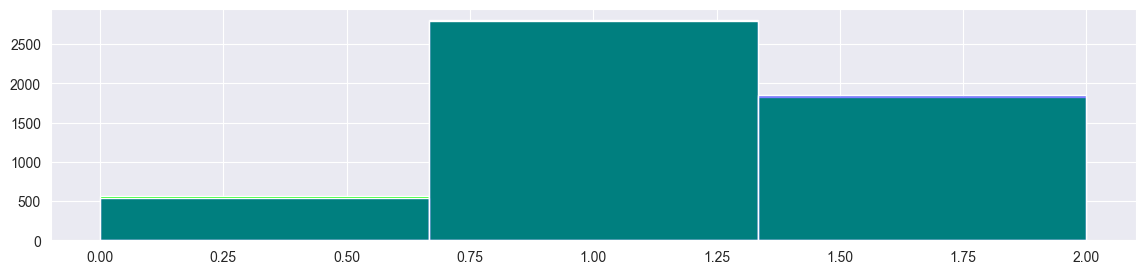

In [69]:
model = KNN(n_neighbors=2, metric=euclidean_distance, kernel=gaussian_kernel, window_type="variable", window_size=1.).fit(train_features.to_numpy(), train_target.to_numpy())
predictions = model.predict(test_features.to_numpy())

print(classification_report(test_target, predictions))
stat_visualize(predictions, test_target)

## Manhattan distance + gaussian kernel + variable window

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       559
           1       0.96      0.95      0.96      2805
           2       0.90      0.92      0.91      1826

    accuracy                           0.93      5190
   macro avg       0.90      0.90      0.90      5190
weighted avg       0.93      0.93      0.93      5190


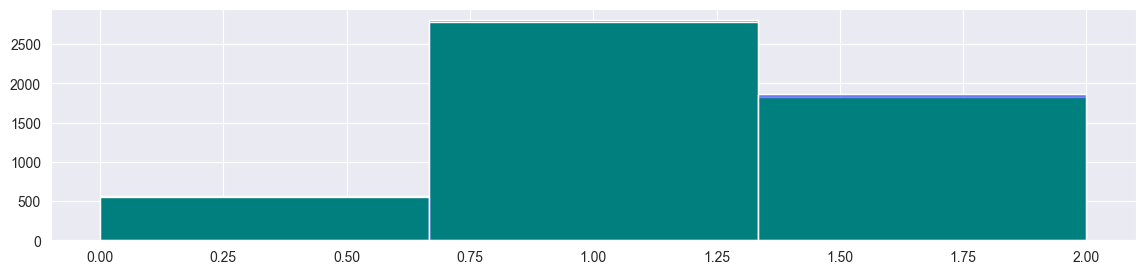

In [70]:
model = KNN(n_neighbors=2, metric=manhattan_distance, kernel=gaussian_kernel, window_type="variable", window_size=1.).fit(train_features.to_numpy(), train_target.to_numpy())
predictions = model.predict(test_features.to_numpy())

print(classification_report(test_target, predictions))
stat_visualize(predictions, test_target)

## Cosine distance + gaussian kernel + variable window

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       559
           1       0.94      0.93      0.94      2805
           2       0.89      0.91      0.90      1826

    accuracy                           0.90      5190
   macro avg       0.87      0.86      0.86      5190
weighted avg       0.90      0.90      0.90      5190


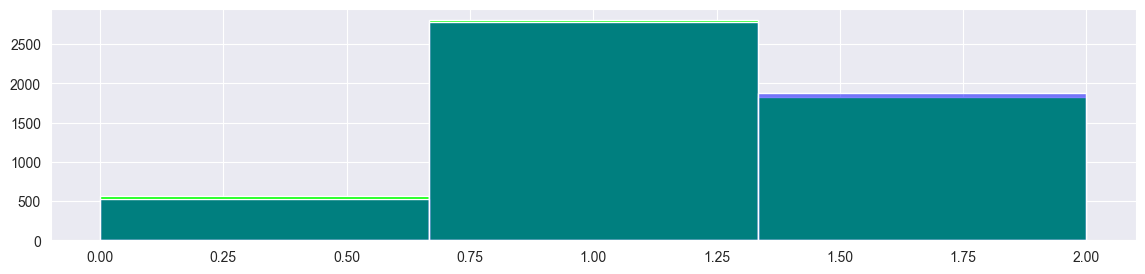

In [71]:
model = KNN(n_neighbors=2, metric=cosine_distance, kernel=gaussian_kernel, window_type="variable", window_size=1.).fit(train_features.to_numpy(), train_target.to_numpy())
predictions = model.predict(test_features.to_numpy())

print(classification_report(test_target, predictions))
stat_visualize(predictions, test_target)

## Manhattan distance + gaussian kernel + fixed window

              precision    recall  f1-score   support

           0       0.22      0.95      0.36       559
           1       0.96      0.56      0.71      2805
           2       0.89      0.57      0.70      1826

    accuracy                           0.61      5190
   macro avg       0.69      0.69      0.59      5190
weighted avg       0.86      0.61      0.67      5190


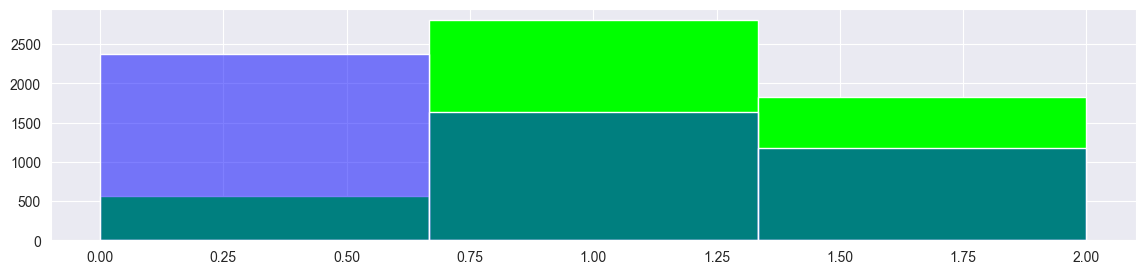

In [72]:
model = KNN(window_size=1., metric=manhattan_distance, kernel=gaussian_kernel, window_type="fixed").fit(train_features.to_numpy(), train_target.to_numpy())
predictions = model.predict(test_features.to_numpy())

print(classification_report(test_target, predictions))
stat_visualize(predictions, test_target)

## Manhattan distance + gaussian kernel + fixed window x3

              precision    recall  f1-score   support

           0       0.23      0.95      0.37       559
           1       0.96      0.58      0.72      2805
           2       0.89      0.58      0.70      1826

    accuracy                           0.62      5190
   macro avg       0.69      0.70      0.60      5190
weighted avg       0.85      0.62      0.68      5190


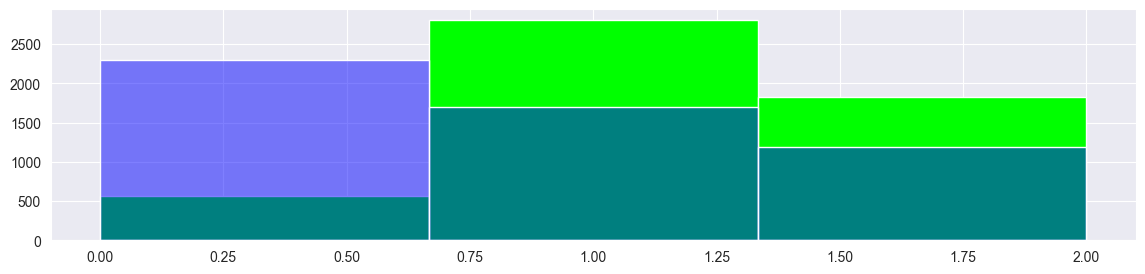

In [73]:
model = KNN(window_size=3., metric=manhattan_distance, kernel=gaussian_kernel, window_type="fixed").fit(train_features.to_numpy(), train_target.to_numpy())
predictions = model.predict(test_features.to_numpy())

print(classification_report(test_target, predictions))
stat_visualize(predictions, test_target)

Выше везде были использованы самописные ядра и метрики. Это было сделано для демонстрации работы алгоритма. 
Из-за этого каждый прогон занимал минуту. Везде дальше будут использоваться готовые реализации scikit, так как
они показывают идентичный результат, но прогон занимает мгновения, ввиду их реализации на плюсах.

# Подбор параметров

## Optuna

In [74]:
def objective(trial: optuna.Trial):
    kernel = trial.suggest_categorical('kernel', ['uniform', 'triangular', 'epanechnikov', 'gaussian'])
    if kernel == 'uniform':
        kernel = uniform_kernel
    elif kernel == 'triangular':
        kernel = triangular_kernel
    elif kernel == 'epanechnikov':
        kernel = epanechnikov_kernel
    else:
        kernel = gaussian_kernel
    
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'cosine'])
    window_type = trial.suggest_categorical('window_type', ['fixed', 'variable'])
    if window_type == 'fixed':
        window_size = trial.suggest_float('window_size', 0.1, 10.)
        model = KNN(window_size=window_size, metric=metric, kernel=kernel, window_type=window_type)
    else:
        n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
        model = KNN(n_neighbors=n_neighbors, metric=metric, kernel=kernel, window_type=window_type)
    model = model.fit(train_features.to_numpy(), train_target.to_numpy())
    y_pred = model.predict(val_features.to_numpy())
    f1 = f1_score(val_target, y_pred, average='weighted')
    return 1. - f1

study = optuna.create_study()
study.optimize(objective, n_trials=500)

study.best_params

[I 2024-03-28 23:28:27,226] A new study created in memory with name: no-name-bfe9024b-2e2f-4077-8891-2230b3c40f11
[I 2024-03-28 23:28:27,653] Trial 0 finished with value: 0.13684957970763034 and parameters: {'kernel': 'uniform', 'metric': 'cosine', 'window_type': 'variable', 'n_neighbors': 6}. Best is trial 0 with value: 0.13684957970763034.
[I 2024-03-28 23:28:27,723] Trial 1 finished with value: 0.32659285534698634 and parameters: {'kernel': 'gaussian', 'metric': 'manhattan', 'window_type': 'fixed', 'window_size': 0.7438494311263025}. Best is trial 0 with value: 0.13684957970763034.
[I 2024-03-28 23:28:27,801] Trial 2 finished with value: 0.2883336255747344 and parameters: {'kernel': 'uniform', 'metric': 'manhattan', 'window_type': 'fixed', 'window_size': 8.96649083729826}. Best is trial 0 with value: 0.13684957970763034.
[I 2024-03-28 23:28:27,880] Trial 3 finished with value: 0.32285115813399023 and parameters: {'kernel': 'epanechnikov', 'metric': 'manhattan', 'window_type': 'fixed

{'kernel': 'gaussian',
 'metric': 'manhattan',
 'window_type': 'variable',
 'n_neighbors': 2}

In [75]:
def objective(trial: optuna.Trial):
    kernel = trial.suggest_categorical('kernel', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'cosine'])
    window_type = trial.suggest_categorical('window_type', ['fixed', 'variable'])
    if window_type == 'fixed':
        window_size = trial.suggest_float('window_size', 0.1, 10.)
        model = RadiusNeighborsClassifier(radius=window_size, metric=metric, weights=kernel, outlier_label='most_frequent')
    else:
        n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
        model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=kernel)
    model = model.fit(train_features.to_numpy(), train_target.to_numpy())
    y_pred = model.predict(val_features.to_numpy())
    f1 = f1_score(val_target, y_pred, average='weighted')
    return 1. - f1

study = optuna.create_study()
study.optimize(objective, n_trials=500)

study.best_params

[I 2024-03-28 23:29:09,741] A new study created in memory with name: no-name-32f44c8f-55fe-4db3-8317-a297b864c009
[I 2024-03-28 23:29:10,560] Trial 0 finished with value: 0.6338474656597676 and parameters: {'kernel': 'uniform', 'metric': 'cosine', 'window_type': 'fixed', 'window_size': 2.7164585371611905}. Best is trial 0 with value: 0.6338474656597676.
[I 2024-03-28 23:29:10,674] Trial 1 finished with value: 0.20187145511277083 and parameters: {'kernel': 'distance', 'metric': 'euclidean', 'window_type': 'fixed', 'window_size': 9.018094848493334}. Best is trial 1 with value: 0.20187145511277083.
[I 2024-03-28 23:29:10,725] Trial 2 finished with value: 0.2500060476934094 and parameters: {'kernel': 'uniform', 'metric': 'manhattan', 'window_type': 'fixed', 'window_size': 3.7468772091369362}. Best is trial 1 with value: 0.20187145511277083.
[I 2024-03-28 23:29:11,412] Trial 3 finished with value: 0.1291594611126371 and parameters: {'kernel': 'distance', 'metric': 'cosine', 'window_type': '

{'kernel': 'distance',
 'metric': 'manhattan',
 'window_type': 'variable',
 'n_neighbors': 6}

## Сравнение библиотечной реализации и DIY на лучших подобранных гиперпараметрах

### Scikit

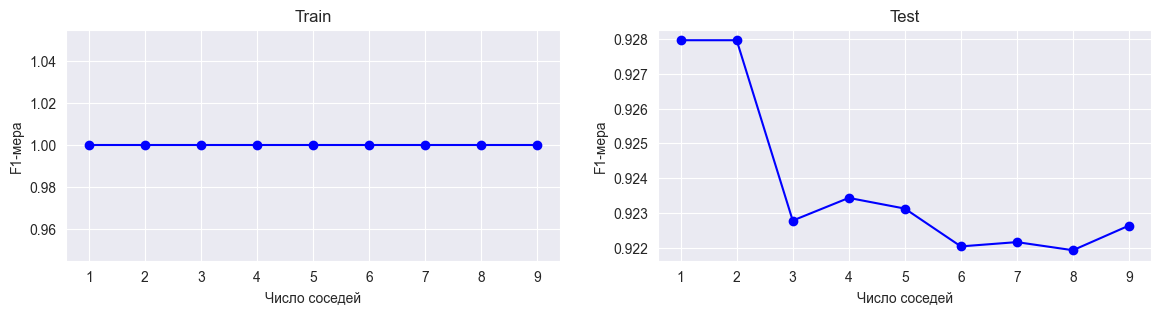

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       559
           1       0.95      0.95      0.95      2805
           2       0.90      0.92      0.91      1826

    accuracy                           0.92      5190
   macro avg       0.90      0.89      0.89      5190
weighted avg       0.92      0.92      0.92      5190


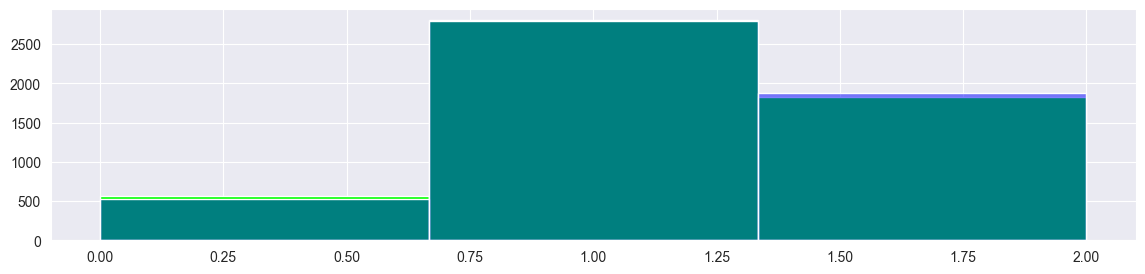

In [83]:
test_neighbors = np.array(range(1, 10))
models = []
for i in test_neighbors:
    models.append(KNeighborsClassifier(n_neighbors=i, metric='manhattan', weights='distance').fit(train_features.to_numpy(), train_target.to_numpy()))


plot_f1_scores(models, test_neighbors)

print(classification_report(test_target, models[5].predict(test_features.to_numpy())))
stat_visualize(models[5].predict(test_features.to_numpy()), test_target)

### DIY

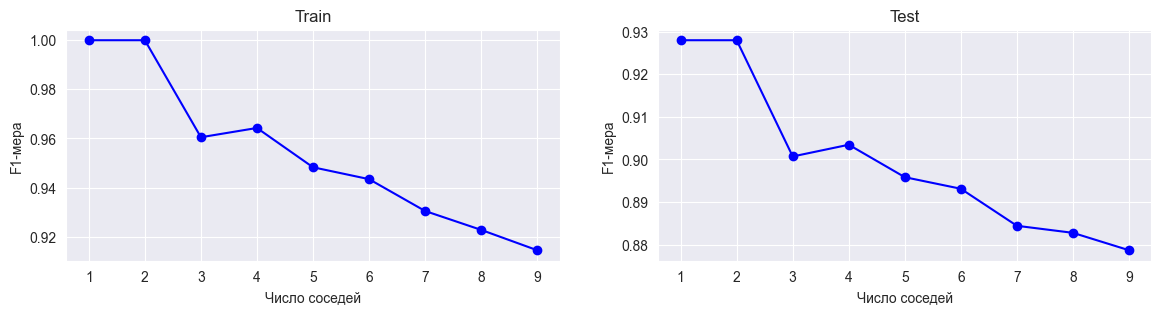

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       559
           1       0.96      0.95      0.96      2805
           2       0.90      0.92      0.91      1826

    accuracy                           0.93      5190
   macro avg       0.90      0.90      0.90      5190
weighted avg       0.93      0.93      0.93      5190


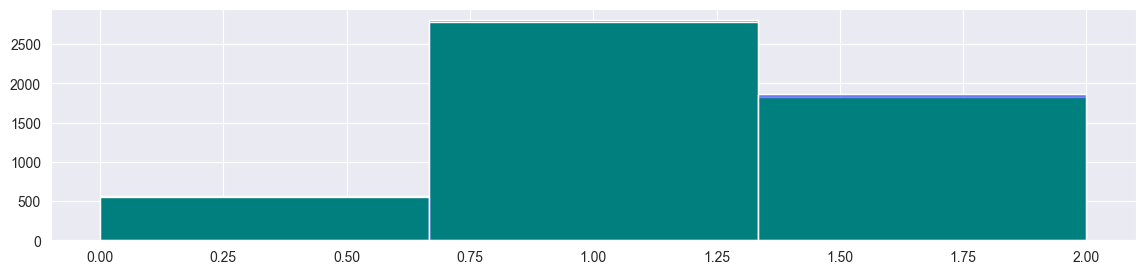

In [84]:
test_neighbors = np.array(range(1, 10))
models = []
for i in test_neighbors:
    models.append(KNN(n_neighbors=i, metric='manhattan', kernel=gaussian_kernel, window_type="variable").fit(train_features.to_numpy(), train_target.to_numpy()))


plot_f1_scores(models, test_neighbors)

print(classification_report(test_target, models[1].predict(test_features.to_numpy())))
stat_visualize(models[1].predict(test_features.to_numpy()), test_target)

# LOWESS

## Релазиация

In [78]:
def lowess(features, target, kernel, model):
    model = model.fit(features.to_numpy(), target.to_numpy())
    prediction = model.predict_proba(features.to_numpy(), to_ignore_first_closest=True)
    weights = np.ones(features.shape[0]) - prediction[np.arange(features.shape[0]), target]
    lowess_weights = kernel(weights)
    return lowess_weights

In [79]:
lowess_weights = lowess(train_features, train_target, triangular_kernel, KNN(n_neighbors=i, metric='manhattan', kernel=gaussian_kernel, window_type="variable"))

## Подбор параметров с Lowess

In [80]:
def objective(trial: optuna.Trial):  
    inner_kernel = trial.suggest_categorical('inner_kernel', ['uniform', 'triangular', 'epanechnikov', 'gaussian'])
    if inner_kernel == 'uniform':
        inner_kernel = uniform_kernel
    elif inner_kernel == 'triangular':
        inner_kernel = triangular_kernel
    elif inner_kernel == 'epanechnikov':
        inner_kernel = epanechnikov_kernel
    else:
        inner_kernel = gaussian_kernel
    
    lowess_kernel = trial.suggest_categorical('lowess_kernel', ['uniform', 'triangular', 'epanechnikov', 'gaussian'])
    if lowess_kernel == 'uniform':
        lowess_kernel = uniform_kernel
    elif lowess_kernel == 'triangular':
        lowess_kernel = triangular_kernel
    elif lowess_kernel == 'epanechnikov':
        lowess_kernel = epanechnikov_kernel
    else:
        lowess_kernel = gaussian_kernel
    
    inner_metric = trial.suggest_categorical('inner_metric', ['euclidean', 'manhattan', 'cosine'])
    inner_window_type = trial.suggest_categorical('inner_window_type', ['fixed', 'variable'])
    if inner_window_type == 'fixed':
        inner_window_size = trial.suggest_float('inner_window_size', 0.1, 10.)
        inner_model = KNN(window_size=inner_window_size, metric=inner_metric, kernel=inner_kernel, window_type=inner_window_type)
    else:
        inner_n_neighbors = trial.suggest_int('inner_n_neighbors', 1, 10)
        inner_model = KNN(n_neighbors=inner_n_neighbors, metric=inner_metric, kernel=inner_kernel, window_type=inner_window_type)

    lowess_weights = lowess(train_features, train_target, lowess_kernel, inner_model)


    outer_kernel = trial.suggest_categorical('outer_kernel', ['uniform', 'triangular', 'epanechnikov', 'gaussian'])
    if outer_kernel == 'uniform':
        outer_kernel = uniform_kernel
    elif outer_kernel == 'triangular':
        outer_kernel = triangular_kernel
    elif outer_kernel == 'epanechnikov':
        outer_kernel = epanechnikov_kernel
    else:
        outer_kernel = gaussian_kernel

    outer_metric = trial.suggest_categorical('outer_metric', ['euclidean', 'manhattan', 'cosine'])
    outer_window_type = trial.suggest_categorical('outer_window_type', ['fixed', 'variable'])
    if outer_window_type == 'fixed':
        outer_window_size = trial.suggest_float('outer_window_size', 0.1, 10.)
        outer_model = KNN(window_size=outer_window_size, metric=outer_metric, kernel=outer_kernel, window_type=outer_window_type)
    else:
        outer_n_neighbors = trial.suggest_int('outer_n_neighbors', 1, 10)
        outer_model = KNN(n_neighbors=outer_n_neighbors, metric=outer_metric, kernel=outer_kernel, window_type=outer_window_type)

    model = outer_model.fit(train_features.to_numpy(), train_target.to_numpy())
    y_pred = model.predict(val_features.to_numpy(), antecedent_weights=lowess_weights)
    f1 = f1_score(val_target, y_pred, average='weighted')
    return 1. - f1

study = optuna.create_study()
study.optimize(objective, n_trials=500)

study.best_params

[I 2024-03-28 23:30:00,734] A new study created in memory with name: no-name-26344b15-555d-4ddd-8093-74f959331d36
[I 2024-03-28 23:30:00,869] Trial 0 finished with value: 0.12093688606281028 and parameters: {'inner_kernel': 'gaussian', 'lowess_kernel': 'triangular', 'inner_metric': 'euclidean', 'inner_window_type': 'variable', 'inner_n_neighbors': 8, 'outer_kernel': 'gaussian', 'outer_metric': 'manhattan', 'outer_window_type': 'variable', 'outer_n_neighbors': 7}. Best is trial 0 with value: 0.12093688606281028.
[I 2024-03-28 23:30:01,313] Trial 1 finished with value: 0.16187784231548552 and parameters: {'inner_kernel': 'uniform', 'lowess_kernel': 'triangular', 'inner_metric': 'euclidean', 'inner_window_type': 'variable', 'inner_n_neighbors': 4, 'outer_kernel': 'uniform', 'outer_metric': 'cosine', 'outer_window_type': 'variable', 'outer_n_neighbors': 10}. Best is trial 0 with value: 0.12093688606281028.
[I 2024-03-28 23:30:01,474] Trial 2 finished with value: 0.09141115616393769 and par

{'inner_kernel': 'gaussian',
 'lowess_kernel': 'gaussian',
 'inner_metric': 'euclidean',
 'inner_window_type': 'fixed',
 'inner_window_size': 9.610277647668905,
 'outer_kernel': 'triangular',
 'outer_metric': 'manhattan',
 'outer_window_type': 'variable',
 'outer_n_neighbors': 3}

## Финальный результат

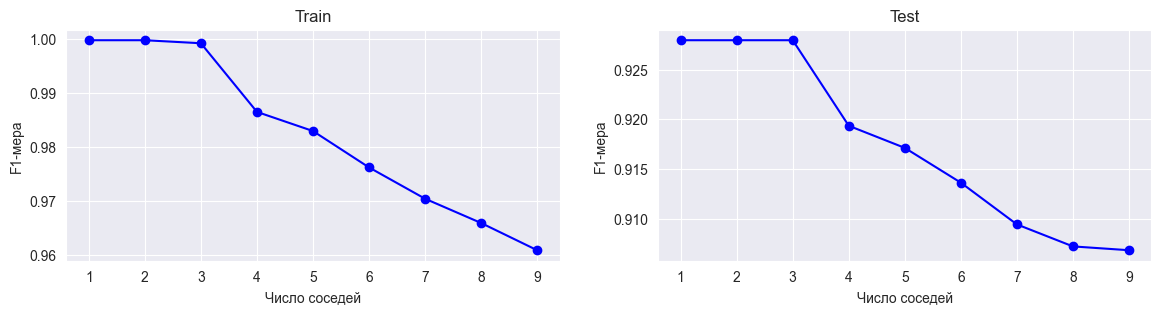

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       559
           1       0.96      0.95      0.96      2805
           2       0.90      0.92      0.91      1826

    accuracy                           0.93      5190
   macro avg       0.90      0.90      0.90      5190
weighted avg       0.93      0.93      0.93      5190


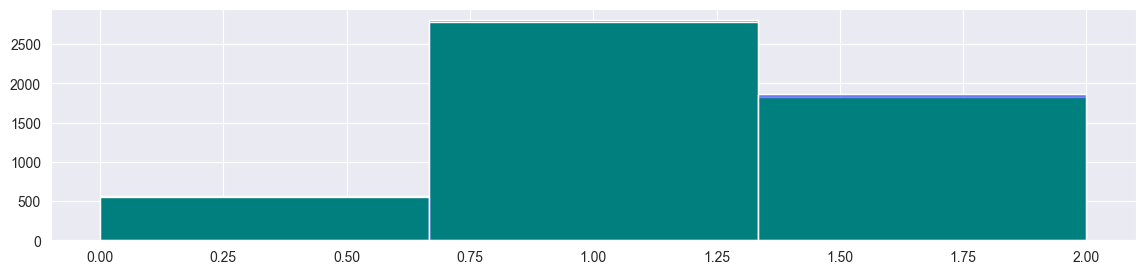

In [82]:
lowess_weights = lowess(train_features, train_target, gaussian_kernel, KNN(window_size=9.610277647668905, metric='euclidean', kernel=gaussian_kernel, window_type="fixed"))

test_neighbors = np.array(range(1, 10))
models = []
for i in test_neighbors:
    models.append(KNN(n_neighbors=i, metric='manhattan', kernel=triangular_kernel, window_type="variable").fit(train_features.to_numpy(), train_target.to_numpy()))

plot_f1_scores(models, test_neighbors, antecedent_weights=lowess_weights)

print(classification_report(test_target, models[2].predict(test_features.to_numpy())))
stat_visualize(models[2].predict(test_features.to_numpy()), test_target)

# Выводы

 Для решения поставленной задачи была проведена работа в несколько этапов:

## Выбор и предобработка данных

Для лабораторной работы был выбран набор данных из курса Анализа данных, который содержит несколько классов и признаков. Данные были преобразованы в числовой вид и нормализованы с использованием z-нормализации.

## Реализация алгоритма ближайших соседей

- Был реализован алгоритм ближайших соседей, поддерживающий как фиксированные, так и переменные размеры окон. Алгоритм поддерживает использование различных ядер, включая равномерное, треугольное, Епанечникова и гауссово. Также реализована поддержка различных метрик расстояния, в том числе косинусного расстояния и расстояния Минковского.
- Для сравнения была выбрана библиотечная реализация алгоритма ближайших соседей из scikit-learn.

## Настройка гиперпараметров

- Используя библиотеку optuna, был проведен поиск оптимальных гиперпараметров для как реализованного, так и библиотечного алгоритма. Поиск велся отдельно для тренировочного множества, без использования тестового множества для валидации.
- Были найдены лучшие значения гиперпараметров для обоих алгоритмов, включая число соседей и параметры ядер.

## Оценка качества

Для выбранной целевой функции качества была оценена зависимость качества на тестовом и тренировочном множествах в зависимости от числа соседей или ширины окна. Графики зависимости качества показали, как изменяется эффективность алгоритма при различных параметрах.

## Поиск аномалий с помощью LOWESS

- Был реализован алгоритм LOWESS для поиска аномалий. Оценка качества алгоритма на тестовом множестве показала его эффективность до и после взвешивания объектов из тренировочного множества.
- Сравнение с библиотечным алгоритмом показало, как введение априорных весов или семплирование может влиять на качество обнаружения аномалий.

## Вывод

В ходе выполнения лабораторной работы были исследованы и реализованы различные аспекты алгоритма ближайших соседей, включая использование разнообразных ядер и метрик расстояния. Оптимизация гиперпараметров позволила улучшить качество классификации. Реализация алгоритма поиска аномалий и его сравнение с библиотечным аналогом демонстрируют важность подхода к взвешиванию данных и выбору методов обработки данных. Полученные результаты подчеркивают значимость глубокой настройки и понимания алгоритмов машинного обучения для повышения их эффективности в конкретных задачах анализа данных.